# Tumor Segmentation Notebook (Single-Device)

This notebook gives a practical workflow to tune training for the PET tumor segmentation task:

1. Build a **stratified** train/val split (control vs patient).
2. Use optional **balanced sampling** to reduce empty-mask dominance.
3. Train `SMP Unet` on one device with `model.to(device)` (no DDP).
4. Use repo `DiceLoss` directly, with optional Dice+BCE blend.
5. Inspect predictions, threshold sensitivity, and hard cases.


In [13]:
import os
import sys
import copy
import random
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler

from tqdm.auto import tqdm


def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "train.py").exists() and (candidate / "criterions").exists():
            return candidate
    raise RuntimeError("Could not locate repository root from current working directory.")


REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print(f"REPO_ROOT = {REPO_ROOT}")

from datasets.TumorSegmentationDataset import (
    TumorSegmentationDataset,
    TumorSegmentationTrainTransform,
    TumorSegmentationEvalTransform,
)
from criterions.dice_loss import DiceLoss

import segmentation_models_pytorch as smp


REPO_ROOT = /home/yslcoat/projects/pytorch-training-toolbox


In [ ]:
@dataclass
class CFG:
    # Data
    data_root: Path = REPO_ROOT / "tumor-segmentation" / "data"
    image_channels: int = 1
    image_height: int = 512
    image_width: int = 400

    # Split / sampling
    val_split: float = 0.2
    split_seed: int = 42
    target_control_fraction_in_sampler: float | None = None  # None = natural sampling.
    # Set to 0.5 for balanced control/patient, or >0.5 to bias toward controls.

    # Augmentation
    enable_augmentations: bool = True
    hflip_prob: float = 0.5
    vflip_prob: float = 0.5
    affine_prob: float = 0.3
    rotate_degrees: float = 30.0
    translate_ratio: float = 0.05
    scale_min: float = 0.95
    scale_max: float = 1.05
    color_jitter_prob: float = 0.0
    brightness: float = 0.15
    contrast: float = 0.15

    # Normalization (PET default; adjust if needed)
    normalize: bool = True
    normalization_mean: tuple[float, ...] = (0.485,)
    normalization_std: tuple[float, ...] = (0.229,)

    # Model
    encoder_name: str = "resnet34"
    encoder_weights: str | None = "imagenet"  # Use ImageNet init by default for this experiment.
    classes: int = 1
    activation: str | None = None

    # Optimization
    epochs: int = 300
    batch_size: int = 32
    num_workers: int = 0  # Keep 0 in notebooks to avoid worker teardown issues
    pin_memory: bool = True
    lr: float = 3e-4
    weight_decay: float = 1e-4

    # Loss formula
    loss_mode: str = "focal_tversky"  # "dice", "bce", "dice_bce", "tversky", "focal_tversky"
    bce_use_pos_weight: bool = True  # Set False for plain BCE without class weighting.
    dice_weight: float = 0.7
    bce_weight: float = 0.3
    tversky_alpha: float = 0.3  # Higher alpha penalizes FP more.
    tversky_beta: float = 0.7
    focal_tversky_gamma: float = 1.33

    # Metrics / inference
    threshold: float = 0.5  # Will be calibrated on validation after training.
    threshold_min_recall: float = 0.6
    threshold_fbeta_beta: float = 0.5
    dice_smooth: float = 1e-6

    # Misc
    seed: int = 42
    use_amp: bool = True


cfg = CFG()


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


seed_everything(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = bool(cfg.use_amp and device.type == "cuda")

print(f"device={device}, use_amp={use_amp}")
print(cfg)


device=cuda, use_amp=True
CFG(data_root=PosixPath('/home/yslcoat/projects/pytorch-training-toolbox/tumor-segmentation/data'), image_channels=1, image_height=512, image_width=400, val_split=0.2, split_seed=42, target_control_fraction_in_sampler=None, enable_augmentations=True, hflip_prob=0.5, vflip_prob=0.5, affine_prob=0.3, rotate_degrees=30.0, translate_ratio=0.05, scale_min=0.95, scale_max=1.05, color_jitter_prob=0.0, brightness=0.15, contrast=0.15, normalize=True, normalization_mean=(0.485,), normalization_std=(0.229,), encoder_name='resnet34', encoder_weights='imagenet', classes=1, activation=None, epochs=300, batch_size=32, num_workers=0, pin_memory=True, lr=0.0003, weight_decay=0.0001, loss_mode='bce', bce_use_pos_weight=True, dice_weight=0.7, bce_weight=0.3, tversky_alpha=0.3, tversky_beta=0.7, focal_tversky_gamma=1.33, threshold=0.5, threshold_min_recall=0.6, threshold_fbeta_beta=0.5, dice_smooth=1e-06, seed=42, use_amp=True)


In [15]:
# Build stratified split from a transform-free base dataset.
base_dataset = TumorSegmentationDataset(
    data_root_dir_path=cfg.data_root,
    image_mask_transform=None,
)

sample_groups = [
    "control" if sample["is_control"] else "patient"
    for sample in base_dataset.samples
]


def stratified_split_indices(groups: list[str], val_split: float, seed: int) -> tuple[list[int], list[int]]:
    if not 0.0 < val_split < 1.0:
        raise ValueError(f"val_split must be in (0, 1), got {val_split}")

    rng = np.random.default_rng(seed)
    group_to_indices: dict[str, list[int]] = {}
    for idx, group in enumerate(groups):
        group_to_indices.setdefault(group, []).append(idx)

    train_idx: list[int] = []
    val_idx: list[int] = []

    for idxs in group_to_indices.values():
        idxs = idxs.copy()
        rng.shuffle(idxs)

        if len(idxs) == 1:
            train_idx.extend(idxs)
            continue

        n_val = int(round(len(idxs) * val_split))
        n_val = max(1, min(len(idxs) - 1, n_val))

        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    return train_idx, val_idx


class ComposeImageMaskTransforms:
    def __init__(self, *transforms):
        self.transforms = [t for t in transforms if t is not None]

    def __call__(self, image: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        for transform in self.transforms:
            image, mask = transform(image, mask)
        return image, mask


class ChannelAndNormalize:
    def __init__(self, image_channels: int, normalize: bool, mean: tuple[float, ...], std: tuple[float, ...]):
        self.image_channels = image_channels
        self.normalize = normalize
        self.mean = mean
        self.std = std

        if self.image_channels not in {1, 3}:
            raise ValueError(f"image_channels must be 1 or 3, got {self.image_channels}")

        if self.normalize:
            if len(self.mean) != self.image_channels or len(self.std) != self.image_channels:
                raise ValueError(
                    "Normalization stats length must match image_channels, got "
                    f"mean={len(self.mean)}, std={len(self.std)}, image_channels={self.image_channels}."
                )
            if any(v <= 0.0 for v in self.std):
                raise ValueError(f"All std values must be > 0, got {self.std}")

    def __call__(self, image: torch.Tensor, mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Dataset currently returns RGB. PET scans are grayscale, so for 1-channel mode
        # we collapse RGB to a single channel.
        if self.image_channels == 1:
            if image.shape[0] == 1:
                image = image
            else:
                image = image.mean(dim=0, keepdim=True)
        else:
            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1)

        if self.normalize:
            mean_t = torch.tensor(self.mean, dtype=image.dtype).view(-1, 1, 1)
            std_t = torch.tensor(self.std, dtype=image.dtype).view(-1, 1, 1)
            image = (image - mean_t) / std_t

        return image, mask


train_indices, val_indices = stratified_split_indices(
    sample_groups,
    val_split=cfg.val_split,
    seed=cfg.split_seed,
)

train_base_transform = TumorSegmentationTrainTransform(
    image_height=cfg.image_height,
    image_width=cfg.image_width,
    hflip_prob=cfg.hflip_prob,
    vflip_prob=cfg.vflip_prob,
    affine_prob=cfg.affine_prob,
    rotate_degrees=cfg.rotate_degrees,
    translate_ratio=cfg.translate_ratio,
    scale_min=cfg.scale_min,
    scale_max=cfg.scale_max,
    color_jitter_prob=cfg.color_jitter_prob,
    brightness=cfg.brightness,
    contrast=cfg.contrast,
)

val_base_transform = TumorSegmentationEvalTransform(
    image_height=cfg.image_height,
    image_width=cfg.image_width,
)

post_transform = ChannelAndNormalize(
    image_channels=cfg.image_channels,
    normalize=cfg.normalize,
    mean=cfg.normalization_mean,
    std=cfg.normalization_std,
)

train_transform = ComposeImageMaskTransforms(train_base_transform, post_transform)
val_transform = ComposeImageMaskTransforms(val_base_transform, post_transform)

train_full_dataset = TumorSegmentationDataset(
    data_root_dir_path=cfg.data_root,
    image_mask_transform=train_transform,
)
val_full_dataset = TumorSegmentationDataset(
    data_root_dir_path=cfg.data_root,
    image_mask_transform=val_transform,
)

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)


def summarize_subset(subset: Subset, subset_name: str) -> None:
    indices = list(subset.indices)
    base_samples = subset.dataset.samples

    num_controls = sum(1 for i in indices if base_samples[i]["is_control"])
    num_patients = len(indices) - num_controls

    empty_masks = 0
    pos_pixels = 0.0
    total_pixels = 0

    for _, mask in subset:
        s = float(mask.sum().item())
        if s == 0.0:
            empty_masks += 1
        pos_pixels += s
        total_pixels += mask.numel()

    print(f"[{subset_name}] samples={len(indices)}")
    print(f"[{subset_name}] controls={num_controls}, patients={num_patients}")
    print(f"[{subset_name}] empty_masks={empty_masks} ({empty_masks / len(indices):.3f})")
    print(f"[{subset_name}] positive_pixel_ratio={pos_pixels / max(total_pixels, 1):.6f}")


def build_class_ratio_sampler(subset: Subset, target_control_fraction: float) -> WeightedRandomSampler:
    if not 0.0 < target_control_fraction < 1.0:
        raise ValueError(
            f"target_control_fraction must be in (0, 1), got {target_control_fraction}."
        )

    indices = list(subset.indices)
    base_samples = subset.dataset.samples
    flags_is_control = [bool(base_samples[i]["is_control"]) for i in indices]

    n_controls = sum(flags_is_control)
    n_patients = len(flags_is_control) - n_controls
    if n_controls == 0 or n_patients == 0:
        raise ValueError("Class-ratio sampling requires both control and patient samples.")

    target_patient_fraction = 1.0 - target_control_fraction
    w_control = target_control_fraction / float(n_controls)
    w_patient = target_patient_fraction / float(n_patients)
    weights = [w_control if is_control else w_patient for is_control in flags_is_control]

    return WeightedRandomSampler(
        weights=torch.tensor(weights, dtype=torch.double),
        num_samples=len(weights),
        replacement=True,
    )


train_sampler = None
if cfg.target_control_fraction_in_sampler is not None:
    train_sampler = build_class_ratio_sampler(
        train_dataset,
        target_control_fraction=cfg.target_control_fraction_in_sampler,
    )

loader_kwargs = {
    "num_workers": cfg.num_workers,
    "pin_memory": bool(cfg.pin_memory and device.type == "cuda"),
}
if cfg.num_workers > 0:
    # Explicit spawn context is safer than fork in interactive notebooks.
    loader_kwargs["multiprocessing_context"] = "spawn"
    loader_kwargs["persistent_workers"] = True

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.batch_size,
    shuffle=(train_sampler is None),
    sampler=train_sampler,
    **loader_kwargs,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    **loader_kwargs,
)

summarize_subset(train_dataset, "train")
summarize_subset(val_dataset, "val")
if cfg.target_control_fraction_in_sampler is None:
    print("train sampling: natural (dataset prior)")
else:
    print(f"train sampling target control fraction={cfg.target_control_fraction_in_sampler:.2f}")
print(f"train batches={len(train_loader)}, val batches={len(val_loader)}")


[train] samples=487
[train] controls=341, patients=146
[train] empty_masks=341 (0.700)
[train] positive_pixel_ratio=0.003781
[val] samples=121
[val] controls=85, patients=36
[val] empty_masks=85 (0.702)
[val] positive_pixel_ratio=0.003453
train sampling: natural (dataset prior)
train batches=16, val batches=4


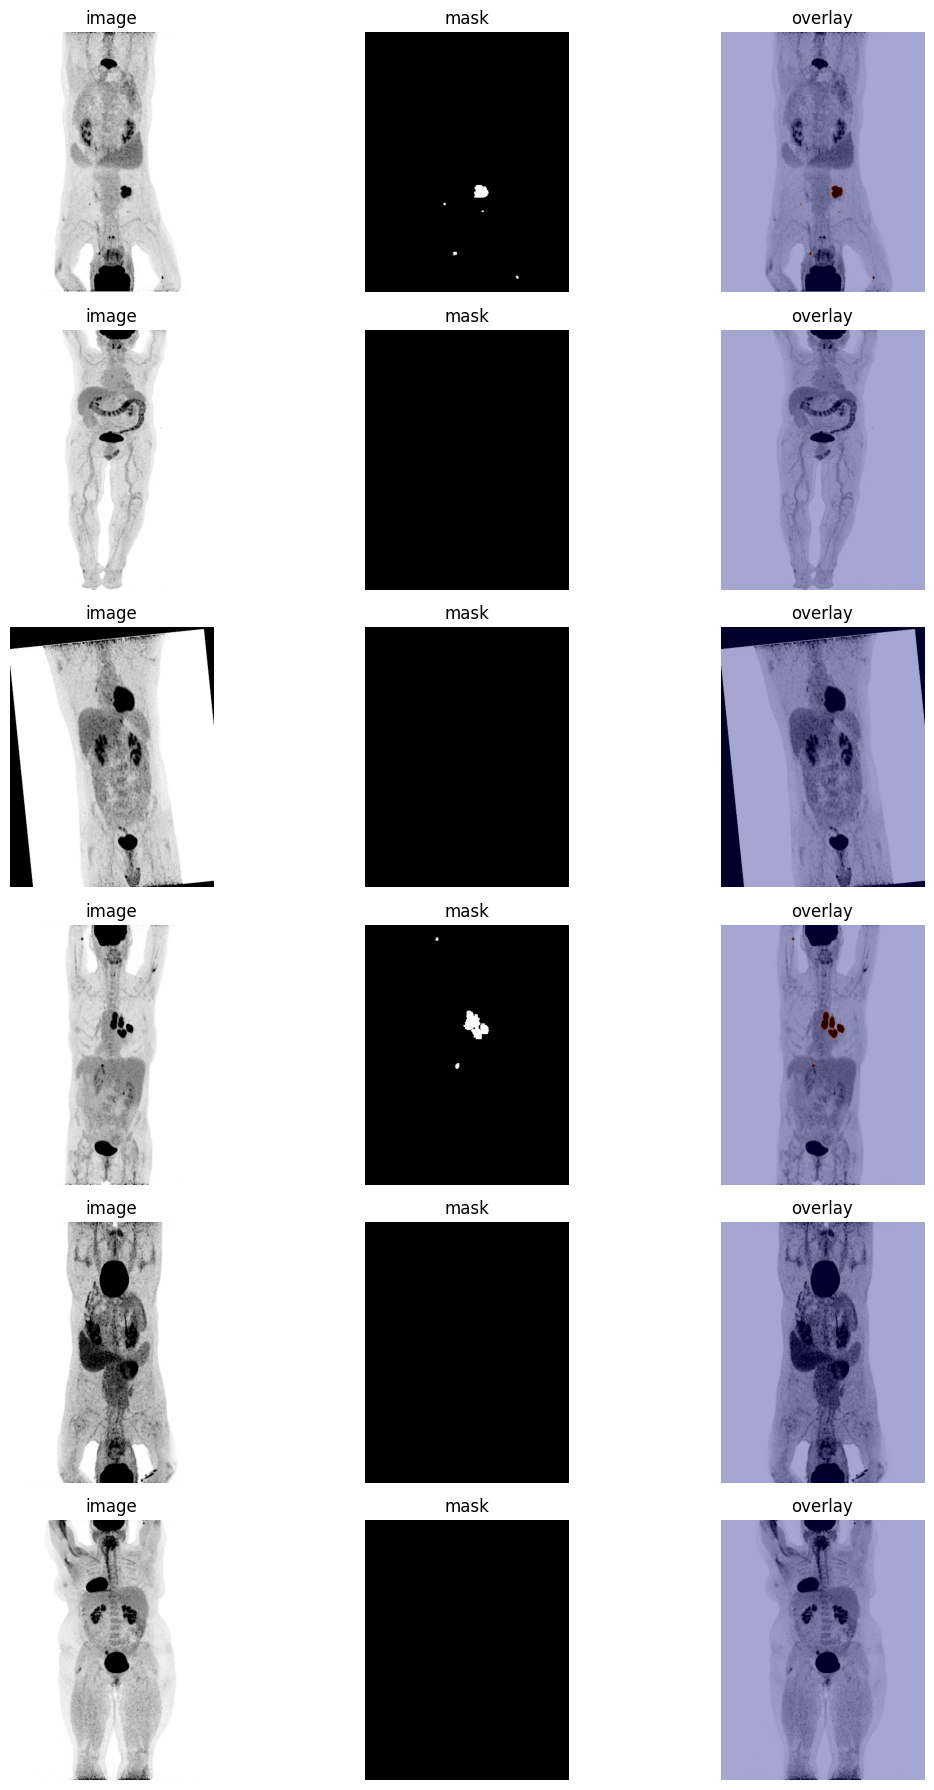

In [16]:
def denormalize_image_tensor(image: torch.Tensor) -> torch.Tensor:
    x = image.detach().cpu().clone()
    if not cfg.normalize:
        return x.clamp(0.0, 1.0)

    mean = torch.tensor(cfg.normalization_mean, dtype=x.dtype).view(-1, 1, 1)
    std = torch.tensor(cfg.normalization_std, dtype=x.dtype).view(-1, 1, 1)
    x = x * std + mean
    return x.clamp(0.0, 1.0)


def show_batch(images: torch.Tensor, masks: torch.Tensor, max_items: int = 6) -> None:
    k = min(max_items, images.shape[0])
    fig, axes = plt.subplots(k, 3, figsize=(12, 3 * k))
    if k == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(k):
        img = denormalize_image_tensor(images[i])
        mask = masks[i, 0].detach().cpu().numpy()

        if img.shape[0] == 1:
            img_np = img[0].numpy()
            axes[i, 0].imshow(img_np, cmap="gray")
            axes[i, 2].imshow(img_np, cmap="gray")
        else:
            img_np = img.permute(1, 2, 0).numpy()
            axes[i, 0].imshow(img_np)
            axes[i, 2].imshow(img_np)

        axes[i, 1].imshow(mask, cmap="gray", vmin=0, vmax=1)
        axes[i, 2].imshow(mask, cmap="jet", alpha=0.35, vmin=0, vmax=1)

        axes[i, 0].set_title("image")
        axes[i, 1].set_title("mask")
        axes[i, 2].set_title("overlay")

        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()


batch_images, batch_masks = next(iter(train_loader))
show_batch(batch_images, batch_masks)


In [17]:
model = smp.Unet(
    encoder_name=cfg.encoder_name,
    encoder_weights=cfg.encoder_weights,
    in_channels=cfg.image_channels,
    classes=cfg.classes,
    activation=cfg.activation,
).to(device)

repo_dice_loss = DiceLoss(
    smooth=cfg.dice_smooth,
    from_logits=True,
    reduction="mean",
)


def estimate_pos_weight(loader: DataLoader, max_batches: int = 32) -> torch.Tensor:
    pos = 0.0
    total = 0.0
    for batch_idx, (_, masks) in enumerate(loader):
        if batch_idx >= max_batches:
            break
        pos += float(masks.sum().item())
        total += float(masks.numel())

    neg = max(total - pos, 1.0)
    pos = max(pos, 1.0)
    return torch.tensor([neg / pos], dtype=torch.float32)


class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight: float, bce_weight: float, pos_weight: torch.Tensor | None = None):
        super().__init__()
        self.dice_weight = float(dice_weight)
        self.bce_weight = float(bce_weight)
        self.dice = repo_dice_loss
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.dice_weight * self.dice(logits, targets) + self.bce_weight * self.bce(logits, targets)


class TverskyLoss(nn.Module):
    def __init__(
        self,
        alpha: float = 0.7,
        beta: float = 0.3,
        smooth: float = 1e-6,
        focal_gamma: float | None = None,
    ):
        super().__init__()
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.smooth = float(smooth)
        self.focal_gamma = None if focal_gamma is None else float(focal_gamma)

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if logits.dim() == targets.dim() + 1 and logits.shape[1] == 1:
            targets = targets.unsqueeze(1)
        if logits.shape != targets.shape:
            raise ValueError(
                "Tversky loss expects logits/targets with same shape, got "
                f"{tuple(logits.shape)} and {tuple(targets.shape)}."
            )

        probs = torch.sigmoid(logits)
        targets = targets.to(dtype=probs.dtype)

        probs_flat = probs.reshape(probs.shape[0], -1)
        targets_flat = targets.reshape(targets.shape[0], -1)

        tp = (probs_flat * targets_flat).sum(dim=1)
        fp = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        fn = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        loss = 1.0 - tversky
        if self.focal_gamma is not None:
            loss = loss.pow(self.focal_gamma)
        return loss.mean()


if cfg.loss_mode == "dice":
    criterion = repo_dice_loss
elif cfg.loss_mode == "bce":
    pos_weight = estimate_pos_weight(train_loader).to(device) if cfg.bce_use_pos_weight else None
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    if pos_weight is None:
        print("Using BCEWithLogitsLoss (no pos_weight)")
    else:
        print(f"Using BCEWithLogitsLoss with pos_weight={pos_weight.item():.4f}")
elif cfg.loss_mode == "dice_bce":
    pos_weight = estimate_pos_weight(train_loader).to(device)
    criterion = DiceBCELoss(cfg.dice_weight, cfg.bce_weight, pos_weight=pos_weight)
    print(f"Using Dice+BCE with pos_weight={pos_weight.item():.4f}")
elif cfg.loss_mode == "tversky":
    criterion = TverskyLoss(
        alpha=cfg.tversky_alpha,
        beta=cfg.tversky_beta,
        smooth=cfg.dice_smooth,
        focal_gamma=None,
    )
    print(
        f"Using Tversky loss (alpha={cfg.tversky_alpha:.2f}, beta={cfg.tversky_beta:.2f})"
    )
elif cfg.loss_mode == "focal_tversky":
    criterion = TverskyLoss(
        alpha=cfg.tversky_alpha,
        beta=cfg.tversky_beta,
        smooth=cfg.dice_smooth,
        focal_gamma=cfg.focal_tversky_gamma,
    )
    print(
        "Using Focal-Tversky loss "
        f"(alpha={cfg.tversky_alpha:.2f}, beta={cfg.tversky_beta:.2f}, gamma={cfg.focal_tversky_gamma:.2f})"
    )
else:
    raise ValueError(
        f"Unsupported loss_mode: {cfg.loss_mode}. "
        "Choose from ['dice', 'bce', 'dice_bce', 'tversky', 'focal_tversky']."
    )

optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

def build_grad_scaler(enabled: bool):
    try:
        return torch.amp.GradScaler("cuda", enabled=enabled)
    except (AttributeError, TypeError):
        return torch.cuda.amp.GradScaler(enabled=enabled)


scaler = build_grad_scaler(enabled=use_amp)
print(model.__class__.__name__, "ready")


Using BCEWithLogitsLoss with pos_weight=263.7786
Unet ready


In [18]:
def autocast_context():
    if use_amp:
        return torch.autocast(device_type="cuda", dtype=torch.float16)
    from contextlib import nullcontext
    return nullcontext()


def _prepare_dice_tensors(outputs: torch.Tensor, targets: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    if outputs.dim() == targets.dim() + 1 and outputs.shape[1] == 1:
        targets = targets.unsqueeze(1)

    if outputs.shape != targets.shape:
        raise ValueError(
            "Dice metric expects outputs/targets with same shape, got "
            f"{tuple(outputs.shape)} and {tuple(targets.shape)}."
        )

    return outputs, targets.to(dtype=outputs.dtype)


def dice_metric(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    from_logits: bool = True,
    threshold: float = 0.5,
    smooth: float = 1e-6,
) -> torch.Tensor:
    outputs, targets = _prepare_dice_tensors(outputs, targets)

    if from_logits:
        outputs = torch.sigmoid(outputs)

    preds = (outputs >= threshold).to(dtype=outputs.dtype)

    preds = preds.reshape(preds.shape[0], -1)
    targets = targets.reshape(targets.shape[0], -1)

    inter = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1)
    dice = (2.0 * inter + smooth) / (union + smooth)
    return dice.mean()


def per_sample_dice_from_logits(logits: torch.Tensor, targets: torch.Tensor, threshold: float, eps: float = 1e-6) -> torch.Tensor:
    logits, targets = _prepare_dice_tensors(logits, targets)

    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).to(dtype=targets.dtype)

    preds_flat = preds.reshape(preds.shape[0], -1)
    targets_flat = targets.reshape(targets.shape[0], -1)

    inter = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1)
    return (2.0 * inter + eps) / (union + eps)


def per_sample_accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor, threshold: float) -> torch.Tensor:
    logits, targets = _prepare_dice_tensors(logits, targets)

    probs = torch.sigmoid(logits)
    preds = probs >= threshold
    targets_bin = targets >= 0.5

    correct = (preds == targets_bin).to(dtype=logits.dtype)
    return correct.reshape(correct.shape[0], -1).mean(dim=1)


def run_epoch(model: nn.Module, loader: DataLoader, train: bool) -> dict[str, float]:
    model.train(mode=train)

    total_loss = 0.0
    total_dice = 0.0
    total_accuracy = 0.0
    total_samples = 0

    pos_only_dice_sum = 0.0
    pos_only_count = 0

    pbar = tqdm(loader, leave=True, desc=("train" if train else "val"))
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with torch.set_grad_enabled(train):
            with autocast_context():
                logits = model(images)
                loss = criterion(logits, targets)

            if train:
                optimizer.zero_grad(set_to_none=True)
                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        with torch.no_grad():
            batch_size = images.shape[0]
            batch_dice = per_sample_dice_from_logits(logits, targets, threshold=cfg.threshold)
            batch_acc = per_sample_accuracy_from_logits(logits, targets, threshold=cfg.threshold)

            total_loss += float(loss.item()) * batch_size
            total_dice += float(batch_dice.mean().item()) * batch_size
            total_accuracy += float(batch_acc.mean().item()) * batch_size
            total_samples += batch_size

            has_positive = targets.reshape(targets.shape[0], -1).sum(dim=1) > 0
            if has_positive.any():
                pos_only_dice_sum += float(batch_dice[has_positive].sum().item())
                pos_only_count += int(has_positive.sum().item())

            avg_loss = total_loss / max(total_samples, 1)
            avg_dice = total_dice / max(total_samples, 1)
            avg_acc = total_accuracy / max(total_samples, 1)
            pbar.set_postfix(loss=f"{avg_loss:.4f}", dice=f"{avg_dice:.4f}", acc=f"{avg_acc:.4f}")

    return {
        "loss": total_loss / max(total_samples, 1),
        "dice": total_dice / max(total_samples, 1),
        "accuracy": total_accuracy / max(total_samples, 1),
        "dice_pos_only": pos_only_dice_sum / max(pos_only_count, 1),
    }


def evaluate_metric_module(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    total = 0.0
    n = 0
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            logits = model(images)
            total += float(
                dice_metric(
                    logits,
                    targets,
                    from_logits=True,
                    threshold=cfg.threshold,
                    smooth=cfg.dice_smooth,
                ).item()
            ) * images.shape[0]
            n += images.shape[0]
    return total / max(n, 1)


In [19]:
history = {
    "train_loss": [],
    "train_dice": [],
    "train_accuracy": [],
    "train_dice_pos_only": [],
    "val_loss": [],
    "val_dice": [],
    "val_accuracy": [],
    "val_dice_pos_only": [],
    "val_dice_metric_module": [],
    "lr": [],
}

best_state = None
best_score = -1.0

for epoch in range(1, cfg.epochs + 1):
    print(f"Starting epoch {epoch}/{cfg.epochs}...")
    train_stats = run_epoch(model, train_loader, train=True)
    val_stats = run_epoch(model, val_loader, train=False)
    val_dice_metric_module = evaluate_metric_module(model, val_loader)


    history["train_loss"].append(train_stats["loss"])
    history["train_dice"].append(train_stats["dice"])
    history["train_accuracy"].append(train_stats["accuracy"])
    history["train_dice_pos_only"].append(train_stats["dice_pos_only"])
    history["val_loss"].append(val_stats["loss"])
    history["val_dice"].append(val_stats["dice"])
    history["val_accuracy"].append(val_stats["accuracy"])
    history["val_dice_pos_only"].append(val_stats["dice_pos_only"])
    history["val_dice_metric_module"].append(val_dice_metric_module)
    history["lr"].append(float(optimizer.param_groups[0]["lr"]))

    score_for_selection = val_stats["dice_pos_only"]
    if score_for_selection > best_score:
        best_score = score_for_selection
        best_state = copy.deepcopy(model.state_dict())

    print(
        f"Epoch {epoch:03d}/{cfg.epochs} | "
        f"train_loss={train_stats['loss']:.4f} train_dice={train_stats['dice']:.4f} train_acc={train_stats['accuracy']:.4f} | "
        f"val_loss={val_stats['loss']:.4f} val_dice={val_stats['dice']:.4f} val_acc={val_stats['accuracy']:.4f} "
        f"val_dice_pos_only={val_stats['dice_pos_only']:.4f} "
        f"val_dice_metric_module={val_dice_metric_module:.4f}"
    )

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best model by val_dice_pos_only={best_score:.4f}")


Starting epoch 1/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 001/300 | train_loss=0.8901 train_dice=nan train_acc=0.6629 | val_loss=1.1962 val_dice=0.0014 val_acc=0.6660 val_dice_pos_only=0.0047 val_dice_metric_module=0.0160
Starting epoch 2/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 002/300 | train_loss=0.5610 train_dice=nan train_acc=0.8539 | val_loss=0.6415 val_dice=0.0277 val_acc=0.8542 val_dice_pos_only=0.0931 val_dice_metric_module=0.0297
Starting epoch 3/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 003/300 | train_loss=0.4436 train_dice=nan train_acc=0.9494 | val_loss=0.4651 val_dice=0.0594 val_acc=0.9388 val_dice_pos_only=0.1997 val_dice_metric_module=0.0594
Starting epoch 4/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 004/300 | train_loss=0.3902 train_dice=nan train_acc=0.9557 | val_loss=0.3988 val_dice=0.0532 val_acc=0.9375 val_dice_pos_only=0.1789 val_dice_metric_module=0.0552
Starting epoch 5/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 005/300 | train_loss=0.3276 train_dice=nan train_acc=0.9643 | val_loss=0.3562 val_dice=0.0988 val_acc=0.9825 val_dice_pos_only=0.3319 val_dice_metric_module=0.0988
Starting epoch 6/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 006/300 | train_loss=0.2845 train_dice=nan train_acc=0.9713 | val_loss=0.3103 val_dice=0.0676 val_acc=0.9645 val_dice_pos_only=0.2271 val_dice_metric_module=0.0694
Starting epoch 7/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 007/300 | train_loss=0.2630 train_dice=nan train_acc=0.9729 | val_loss=0.2869 val_dice=0.0646 val_acc=0.9567 val_dice_pos_only=0.2172 val_dice_metric_module=0.0647
Starting epoch 8/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 008/300 | train_loss=0.2696 train_dice=nan train_acc=0.9644 | val_loss=0.3220 val_dice=0.0505 val_acc=0.9174 val_dice_pos_only=0.1698 val_dice_metric_module=0.0505
Starting epoch 9/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 009/300 | train_loss=0.2365 train_dice=nan train_acc=0.9646 | val_loss=0.2381 val_dice=0.0999 val_acc=0.9774 val_dice_pos_only=0.3357 val_dice_metric_module=0.0999
Starting epoch 10/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 010/300 | train_loss=0.2216 train_dice=nan train_acc=0.9751 | val_loss=0.2514 val_dice=0.0671 val_acc=0.9437 val_dice_pos_only=0.2254 val_dice_metric_module=0.0671
Starting epoch 11/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 011/300 | train_loss=0.1999 train_dice=nan train_acc=0.9687 | val_loss=0.2124 val_dice=0.1243 val_acc=0.9838 val_dice_pos_only=0.3622 val_dice_metric_module=0.1243
Starting epoch 12/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 012/300 | train_loss=0.1859 train_dice=nan train_acc=0.9770 | val_loss=0.2704 val_dice=0.1371 val_acc=0.9861 val_dice_pos_only=0.3775 val_dice_metric_module=0.1371
Starting epoch 13/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 013/300 | train_loss=0.1617 train_dice=nan train_acc=0.9793 | val_loss=0.1841 val_dice=0.1184 val_acc=0.9809 val_dice_pos_only=0.3148 val_dice_metric_module=0.1184
Starting epoch 14/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 014/300 | train_loss=0.1684 train_dice=nan train_acc=0.9735 | val_loss=0.1985 val_dice=0.1178 val_acc=0.9856 val_dice_pos_only=0.3682 val_dice_metric_module=0.1178
Starting epoch 15/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 015/300 | train_loss=0.1607 train_dice=nan train_acc=0.9746 | val_loss=0.3557 val_dice=0.1906 val_acc=0.9917 val_dice_pos_only=0.4460 val_dice_metric_module=0.1906
Starting epoch 16/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 016/300 | train_loss=0.1863 train_dice=nan train_acc=0.9668 | val_loss=0.1681 val_dice=0.0851 val_acc=0.9686 val_dice_pos_only=0.2582 val_dice_metric_module=0.0851
Starting epoch 17/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 017/300 | train_loss=0.1611 train_dice=nan train_acc=0.9750 | val_loss=0.1860 val_dice=0.0684 val_acc=0.9572 val_dice_pos_only=0.2298 val_dice_metric_module=0.0684
Starting epoch 18/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 018/300 | train_loss=0.1524 train_dice=nan train_acc=0.9769 | val_loss=0.1650 val_dice=0.0801 val_acc=0.9653 val_dice_pos_only=0.2692 val_dice_metric_module=0.0801
Starting epoch 19/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 019/300 | train_loss=0.1730 train_dice=nan train_acc=0.9622 | val_loss=0.2302 val_dice=0.1035 val_acc=0.9780 val_dice_pos_only=0.3478 val_dice_metric_module=0.1035
Starting epoch 20/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 020/300 | train_loss=0.1766 train_dice=nan train_acc=0.9628 | val_loss=0.2315 val_dice=0.1161 val_acc=0.9847 val_dice_pos_only=0.3901 val_dice_metric_module=0.1162
Starting epoch 21/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 021/300 | train_loss=0.1624 train_dice=nan train_acc=0.9659 | val_loss=0.1634 val_dice=0.0805 val_acc=0.9693 val_dice_pos_only=0.2707 val_dice_metric_module=0.0805
Starting epoch 22/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 022/300 | train_loss=0.1411 train_dice=nan train_acc=0.9770 | val_loss=0.1573 val_dice=0.1179 val_acc=0.9857 val_dice_pos_only=0.3963 val_dice_metric_module=0.1179
Starting epoch 23/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 023/300 | train_loss=0.1453 train_dice=nan train_acc=0.9778 | val_loss=0.2416 val_dice=0.0518 val_acc=0.9367 val_dice_pos_only=0.1742 val_dice_metric_module=0.0537
Starting epoch 24/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 024/300 | train_loss=0.1414 train_dice=nan train_acc=0.9630 | val_loss=0.2593 val_dice=0.1542 val_acc=0.9894 val_dice_pos_only=0.4348 val_dice_metric_module=0.1541
Starting epoch 25/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 025/300 | train_loss=0.1576 train_dice=nan train_acc=0.9714 | val_loss=0.1739 val_dice=0.0873 val_acc=0.9711 val_dice_pos_only=0.2935 val_dice_metric_module=0.0874
Starting epoch 26/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 026/300 | train_loss=0.1385 train_dice=nan train_acc=0.9761 | val_loss=0.1712 val_dice=0.0705 val_acc=0.9554 val_dice_pos_only=0.2368 val_dice_metric_module=0.0705
Starting epoch 27/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 027/300 | train_loss=0.1520 train_dice=nan train_acc=0.9620 | val_loss=0.1636 val_dice=0.0912 val_acc=0.9753 val_dice_pos_only=0.3065 val_dice_metric_module=0.0912
Starting epoch 28/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 028/300 | train_loss=0.1144 train_dice=nan train_acc=0.9771 | val_loss=0.1395 val_dice=0.1184 val_acc=0.9808 val_dice_pos_only=0.3423 val_dice_metric_module=0.1184
Starting epoch 29/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 029/300 | train_loss=0.0963 train_dice=nan train_acc=0.9822 | val_loss=0.2113 val_dice=0.2049 val_acc=0.9889 val_dice_pos_only=0.4111 val_dice_metric_module=0.2050
Starting epoch 30/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 030/300 | train_loss=0.0988 train_dice=nan train_acc=0.9836 | val_loss=0.1430 val_dice=0.0937 val_acc=0.9737 val_dice_pos_only=0.2871 val_dice_metric_module=0.0937
Starting epoch 31/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 031/300 | train_loss=0.1110 train_dice=nan train_acc=0.9803 | val_loss=0.1575 val_dice=0.0702 val_acc=0.9591 val_dice_pos_only=0.2361 val_dice_metric_module=0.0702
Starting epoch 32/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 032/300 | train_loss=0.1122 train_dice=nan train_acc=0.9752 | val_loss=0.1259 val_dice=0.0898 val_acc=0.9740 val_dice_pos_only=0.3017 val_dice_metric_module=0.0897
Starting epoch 33/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 033/300 | train_loss=0.1267 train_dice=nan train_acc=0.9727 | val_loss=0.1398 val_dice=0.0807 val_acc=0.9643 val_dice_pos_only=0.2712 val_dice_metric_module=0.0807
Starting epoch 34/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 034/300 | train_loss=0.1073 train_dice=nan train_acc=0.9784 | val_loss=0.4088 val_dice=0.1431 val_acc=0.9938 val_dice_pos_only=0.4811 val_dice_metric_module=0.1431
Starting epoch 35/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 035/300 | train_loss=0.1065 train_dice=nan train_acc=0.9830 | val_loss=0.1643 val_dice=0.1823 val_acc=0.9867 val_dice_pos_only=0.3904 val_dice_metric_module=0.1823
Starting epoch 36/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 036/300 | train_loss=0.0967 train_dice=nan train_acc=0.9815 | val_loss=0.4480 val_dice=0.2353 val_acc=0.9924 val_dice_pos_only=0.4296 val_dice_metric_module=0.2353
Starting epoch 37/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 037/300 | train_loss=0.1131 train_dice=nan train_acc=0.9735 | val_loss=0.2487 val_dice=0.1335 val_acc=0.9890 val_dice_pos_only=0.4209 val_dice_metric_module=0.1335
Starting epoch 38/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 038/300 | train_loss=0.1138 train_dice=nan train_acc=0.9782 | val_loss=0.3321 val_dice=0.0461 val_acc=0.9078 val_dice_pos_only=0.1548 val_dice_metric_module=0.0481
Starting epoch 39/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 039/300 | train_loss=0.1186 train_dice=nan train_acc=0.9723 | val_loss=0.2404 val_dice=0.1377 val_acc=0.9865 val_dice_pos_only=0.4629 val_dice_metric_module=0.1378
Starting epoch 40/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 040/300 | train_loss=0.1144 train_dice=nan train_acc=0.9780 | val_loss=0.1293 val_dice=0.0927 val_acc=0.9712 val_dice_pos_only=0.2561 val_dice_metric_module=0.0927
Starting epoch 41/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 041/300 | train_loss=0.1012 train_dice=nan train_acc=0.9787 | val_loss=0.4002 val_dice=0.2342 val_acc=0.9921 val_dice_pos_only=0.4817 val_dice_metric_module=0.2342
Starting epoch 42/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 042/300 | train_loss=0.1303 train_dice=0.1087 train_acc=0.9803 | val_loss=0.5517 val_dice=0.4698 val_acc=0.9840 val_dice_pos_only=0.3574 val_dice_metric_module=0.4700
Starting epoch 43/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 043/300 | train_loss=0.1791 train_dice=nan train_acc=0.9543 | val_loss=0.2149 val_dice=0.1096 val_acc=0.9767 val_dice_pos_only=0.3684 val_dice_metric_module=0.1096
Starting epoch 44/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 044/300 | train_loss=0.1387 train_dice=nan train_acc=0.9701 | val_loss=0.2191 val_dice=0.0666 val_acc=0.9543 val_dice_pos_only=0.1960 val_dice_metric_module=0.0685
Starting epoch 45/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 045/300 | train_loss=0.1229 train_dice=nan train_acc=0.9751 | val_loss=0.2261 val_dice=0.0527 val_acc=0.9349 val_dice_pos_only=0.1771 val_dice_metric_module=0.0527
Starting epoch 46/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 046/300 | train_loss=0.1395 train_dice=nan train_acc=0.9620 | val_loss=0.3394 val_dice=0.1437 val_acc=0.9868 val_dice_pos_only=0.3719 val_dice_metric_module=0.1437
Starting epoch 47/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 047/300 | train_loss=0.1460 train_dice=nan train_acc=0.9696 | val_loss=0.2994 val_dice=0.0423 val_acc=0.9056 val_dice_pos_only=0.1420 val_dice_metric_module=0.0440
Starting epoch 48/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 048/300 | train_loss=0.1201 train_dice=nan train_acc=0.9710 | val_loss=0.6593 val_dice=0.2602 val_acc=0.9934 val_dice_pos_only=0.4300 val_dice_metric_module=0.2602
Starting epoch 49/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 049/300 | train_loss=0.1086 train_dice=nan train_acc=0.9814 | val_loss=0.2071 val_dice=0.1589 val_acc=0.9864 val_dice_pos_only=0.3952 val_dice_metric_module=0.1589
Starting epoch 50/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 050/300 | train_loss=0.0967 train_dice=nan train_acc=0.9767 | val_loss=0.4339 val_dice=0.1155 val_acc=0.9885 val_dice_pos_only=0.3882 val_dice_metric_module=0.1155
Starting epoch 51/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 051/300 | train_loss=0.0926 train_dice=nan train_acc=0.9831 | val_loss=0.3188 val_dice=0.1438 val_acc=0.9913 val_dice_pos_only=0.4556 val_dice_metric_module=0.1438
Starting epoch 52/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 052/300 | train_loss=0.1191 train_dice=0.1247 train_acc=0.9776 | val_loss=0.3135 val_dice=0.0508 val_acc=0.9015 val_dice_pos_only=0.1706 val_dice_metric_module=0.0508
Starting epoch 53/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 053/300 | train_loss=0.1322 train_dice=nan train_acc=0.9674 | val_loss=0.1438 val_dice=0.0956 val_acc=0.9744 val_dice_pos_only=0.3212 val_dice_metric_module=0.0956
Starting epoch 54/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 054/300 | train_loss=0.1060 train_dice=nan train_acc=0.9776 | val_loss=0.1987 val_dice=0.1314 val_acc=0.9891 val_dice_pos_only=0.4416 val_dice_metric_module=0.1314
Starting epoch 55/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 055/300 | train_loss=0.0989 train_dice=nan train_acc=0.9812 | val_loss=0.1548 val_dice=0.0895 val_acc=0.9674 val_dice_pos_only=0.3009 val_dice_metric_module=0.0895
Starting epoch 56/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 056/300 | train_loss=0.0926 train_dice=nan train_acc=0.9804 | val_loss=0.1865 val_dice=0.1211 val_acc=0.9875 val_dice_pos_only=0.4072 val_dice_metric_module=0.1211
Starting epoch 57/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 057/300 | train_loss=0.1261 train_dice=nan train_acc=0.9696 | val_loss=0.1446 val_dice=0.0932 val_acc=0.9679 val_dice_pos_only=0.2855 val_dice_metric_module=0.0932
Starting epoch 58/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 058/300 | train_loss=0.1136 train_dice=nan train_acc=0.9752 | val_loss=0.2853 val_dice=0.1722 val_acc=0.9888 val_dice_pos_only=0.4396 val_dice_metric_module=0.1721
Starting epoch 59/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 059/300 | train_loss=0.0987 train_dice=0.1031 train_acc=0.9796 | val_loss=0.1453 val_dice=0.0753 val_acc=0.9607 val_dice_pos_only=0.2530 val_dice_metric_module=0.0753
Starting epoch 60/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 060/300 | train_loss=0.1074 train_dice=nan train_acc=0.9755 | val_loss=0.1439 val_dice=0.0698 val_acc=0.9640 val_dice_pos_only=0.2347 val_dice_metric_module=0.0699
Starting epoch 61/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 061/300 | train_loss=0.0929 train_dice=nan train_acc=0.9786 | val_loss=0.2548 val_dice=0.2110 val_acc=0.9906 val_dice_pos_only=0.4591 val_dice_metric_module=0.2110
Starting epoch 62/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 062/300 | train_loss=0.0827 train_dice=nan train_acc=0.9806 | val_loss=0.3554 val_dice=0.1959 val_acc=0.9926 val_dice_pos_only=0.4640 val_dice_metric_module=0.1959
Starting epoch 63/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 063/300 | train_loss=0.0997 train_dice=nan train_acc=0.9826 | val_loss=0.1608 val_dice=0.0690 val_acc=0.9599 val_dice_pos_only=0.2320 val_dice_metric_module=0.0690
Starting epoch 64/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 064/300 | train_loss=0.1243 train_dice=nan train_acc=0.9698 | val_loss=0.1837 val_dice=0.0977 val_acc=0.9757 val_dice_pos_only=0.3283 val_dice_metric_module=0.0976
Starting epoch 65/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 065/300 | train_loss=0.1019 train_dice=nan train_acc=0.9750 | val_loss=0.2593 val_dice=0.1795 val_acc=0.9906 val_dice_pos_only=0.4921 val_dice_metric_module=0.1795
Starting epoch 66/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 066/300 | train_loss=0.1024 train_dice=nan train_acc=0.9825 | val_loss=0.1664 val_dice=0.1436 val_acc=0.9826 val_dice_pos_only=0.3714 val_dice_metric_module=0.1436
Starting epoch 67/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 067/300 | train_loss=0.0951 train_dice=nan train_acc=0.9763 | val_loss=0.1762 val_dice=0.1299 val_acc=0.9863 val_dice_pos_only=0.4090 val_dice_metric_module=0.1299
Starting epoch 68/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 068/300 | train_loss=0.0811 train_dice=nan train_acc=0.9852 | val_loss=0.1339 val_dice=0.1044 val_acc=0.9769 val_dice_pos_only=0.3507 val_dice_metric_module=0.1044
Starting epoch 69/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 069/300 | train_loss=0.1132 train_dice=nan train_acc=0.9743 | val_loss=0.2512 val_dice=0.0846 val_acc=0.9687 val_dice_pos_only=0.2843 val_dice_metric_module=0.0845
Starting epoch 70/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 070/300 | train_loss=0.1664 train_dice=0.0749 train_acc=0.9578 | val_loss=0.2240 val_dice=0.0451 val_acc=0.9233 val_dice_pos_only=0.1514 val_dice_metric_module=0.0466
Starting epoch 71/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 071/300 | train_loss=0.1204 train_dice=nan train_acc=0.9733 | val_loss=0.1135 val_dice=0.0848 val_acc=0.9727 val_dice_pos_only=0.2849 val_dice_metric_module=0.0868
Starting epoch 72/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 072/300 | train_loss=0.0974 train_dice=nan train_acc=0.9777 | val_loss=0.1202 val_dice=0.1191 val_acc=0.9821 val_dice_pos_only=0.3447 val_dice_metric_module=0.1191
Starting epoch 73/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 073/300 | train_loss=0.0912 train_dice=nan train_acc=0.9835 | val_loss=0.2214 val_dice=0.1398 val_acc=0.9886 val_dice_pos_only=0.4419 val_dice_metric_module=0.1398
Starting epoch 74/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 074/300 | train_loss=0.0990 train_dice=nan train_acc=0.9766 | val_loss=0.1308 val_dice=0.0849 val_acc=0.9730 val_dice_pos_only=0.2855 val_dice_metric_module=0.0850
Starting epoch 75/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 075/300 | train_loss=0.0854 train_dice=nan train_acc=0.9808 | val_loss=0.2462 val_dice=0.2143 val_acc=0.9920 val_dice_pos_only=0.4982 val_dice_metric_module=0.2144
Starting epoch 76/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 076/300 | train_loss=0.0973 train_dice=nan train_acc=0.9788 | val_loss=0.1632 val_dice=0.1367 val_acc=0.9900 val_dice_pos_only=0.4594 val_dice_metric_module=0.1368
Starting epoch 77/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 077/300 | train_loss=0.0899 train_dice=nan train_acc=0.9831 | val_loss=0.1331 val_dice=0.0705 val_acc=0.9693 val_dice_pos_only=0.2370 val_dice_metric_module=0.0724
Starting epoch 78/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 078/300 | train_loss=0.0786 train_dice=nan train_acc=0.9802 | val_loss=0.2455 val_dice=0.1714 val_acc=0.9915 val_dice_pos_only=0.4649 val_dice_metric_module=0.1714
Starting epoch 79/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 079/300 | train_loss=0.0732 train_dice=nan train_acc=0.9849 | val_loss=0.1155 val_dice=0.0969 val_acc=0.9754 val_dice_pos_only=0.3258 val_dice_metric_module=0.0970
Starting epoch 80/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 080/300 | train_loss=0.0713 train_dice=nan train_acc=0.9851 | val_loss=0.1325 val_dice=0.1213 val_acc=0.9854 val_dice_pos_only=0.3799 val_dice_metric_module=0.1213
Starting epoch 81/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 081/300 | train_loss=0.0793 train_dice=nan train_acc=0.9821 | val_loss=0.2833 val_dice=0.1091 val_acc=0.9883 val_dice_pos_only=0.3665 val_dice_metric_module=0.1090
Starting epoch 82/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 082/300 | train_loss=0.0933 train_dice=nan train_acc=0.9798 | val_loss=0.6896 val_dice=0.0308 val_acc=0.8211 val_dice_pos_only=0.1034 val_dice_metric_module=0.0325
Starting epoch 83/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 083/300 | train_loss=0.0947 train_dice=nan train_acc=0.9763 | val_loss=0.1197 val_dice=0.1438 val_acc=0.9812 val_dice_pos_only=0.3443 val_dice_metric_module=0.1437
Starting epoch 84/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 084/300 | train_loss=0.0980 train_dice=nan train_acc=0.9824 | val_loss=0.1111 val_dice=0.0998 val_acc=0.9773 val_dice_pos_only=0.3354 val_dice_metric_module=0.0998
Starting epoch 85/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 085/300 | train_loss=0.0948 train_dice=nan train_acc=0.9730 | val_loss=0.2631 val_dice=0.1567 val_acc=0.9909 val_dice_pos_only=0.4711 val_dice_metric_module=0.1567
Starting epoch 86/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 086/300 | train_loss=0.0848 train_dice=nan train_acc=0.9831 | val_loss=0.1136 val_dice=0.1167 val_acc=0.9854 val_dice_pos_only=0.3923 val_dice_metric_module=0.1167
Starting epoch 87/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 087/300 | train_loss=0.0693 train_dice=nan train_acc=0.9837 | val_loss=0.2091 val_dice=0.1977 val_acc=0.9911 val_dice_pos_only=0.4701 val_dice_metric_module=0.1977
Starting epoch 88/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 088/300 | train_loss=0.0828 train_dice=nan train_acc=0.9864 | val_loss=0.1333 val_dice=0.0770 val_acc=0.9619 val_dice_pos_only=0.2589 val_dice_metric_module=0.0770
Starting epoch 89/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 089/300 | train_loss=0.0990 train_dice=nan train_acc=0.9724 | val_loss=0.1822 val_dice=0.1616 val_acc=0.9864 val_dice_pos_only=0.3765 val_dice_metric_module=0.1617
Starting epoch 90/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 090/300 | train_loss=0.0729 train_dice=nan train_acc=0.9842 | val_loss=0.2487 val_dice=0.1556 val_acc=0.9922 val_dice_pos_only=0.4675 val_dice_metric_module=0.1556
Starting epoch 91/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 091/300 | train_loss=0.0687 train_dice=0.1355 train_acc=0.9850 | val_loss=0.1782 val_dice=0.1285 val_acc=0.9849 val_dice_pos_only=0.3487 val_dice_metric_module=0.1285
Starting epoch 92/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 092/300 | train_loss=0.0628 train_dice=nan train_acc=0.9862 | val_loss=0.2636 val_dice=0.1664 val_acc=0.9911 val_dice_pos_only=0.4483 val_dice_metric_module=0.1665
Starting epoch 93/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 093/300 | train_loss=0.0631 train_dice=nan train_acc=0.9872 | val_loss=0.3262 val_dice=0.2184 val_acc=0.9908 val_dice_pos_only=0.4284 val_dice_metric_module=0.2184
Starting epoch 94/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 094/300 | train_loss=0.0754 train_dice=nan train_acc=0.9842 | val_loss=0.1108 val_dice=0.0903 val_acc=0.9740 val_dice_pos_only=0.3034 val_dice_metric_module=0.0903
Starting epoch 95/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 095/300 | train_loss=0.0697 train_dice=nan train_acc=0.9829 | val_loss=0.1047 val_dice=0.1254 val_acc=0.9835 val_dice_pos_only=0.3659 val_dice_metric_module=0.1255
Starting epoch 96/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 096/300 | train_loss=0.0720 train_dice=nan train_acc=0.9871 | val_loss=0.1218 val_dice=0.1590 val_acc=0.9873 val_dice_pos_only=0.4230 val_dice_metric_module=0.1590
Starting epoch 97/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 097/300 | train_loss=0.0771 train_dice=nan train_acc=0.9838 | val_loss=0.1265 val_dice=0.0827 val_acc=0.9678 val_dice_pos_only=0.2778 val_dice_metric_module=0.0826
Starting epoch 98/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 098/300 | train_loss=0.0908 train_dice=nan train_acc=0.9771 | val_loss=0.3693 val_dice=0.3415 val_acc=0.9916 val_dice_pos_only=0.5088 val_dice_metric_module=0.3415
Starting epoch 99/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 099/300 | train_loss=0.0803 train_dice=nan train_acc=0.9824 | val_loss=0.1574 val_dice=0.1527 val_acc=0.9840 val_dice_pos_only=0.3743 val_dice_metric_module=0.1527
Starting epoch 100/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 100/300 | train_loss=0.0678 train_dice=nan train_acc=0.9840 | val_loss=0.1600 val_dice=0.1590 val_acc=0.9890 val_dice_pos_only=0.4512 val_dice_metric_module=0.1590
Starting epoch 101/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 101/300 | train_loss=0.0691 train_dice=nan train_acc=0.9844 | val_loss=0.1403 val_dice=0.1275 val_acc=0.9843 val_dice_pos_only=0.3730 val_dice_metric_module=0.1275
Starting epoch 102/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 102/300 | train_loss=0.0665 train_dice=nan train_acc=0.9842 | val_loss=0.1946 val_dice=0.1283 val_acc=0.9893 val_dice_pos_only=0.4311 val_dice_metric_module=0.1282
Starting epoch 103/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 103/300 | train_loss=0.0804 train_dice=nan train_acc=0.9833 | val_loss=0.1281 val_dice=0.1705 val_acc=0.9844 val_dice_pos_only=0.3787 val_dice_metric_module=0.1788
Starting epoch 104/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 104/300 | train_loss=0.0574 train_dice=nan train_acc=0.9874 | val_loss=0.3324 val_dice=0.2240 val_acc=0.9922 val_dice_pos_only=0.4473 val_dice_metric_module=0.2239
Starting epoch 105/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 105/300 | train_loss=0.0619 train_dice=nan train_acc=0.9889 | val_loss=0.1322 val_dice=0.1085 val_acc=0.9771 val_dice_pos_only=0.3090 val_dice_metric_module=0.1085
Starting epoch 106/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 106/300 | train_loss=0.0686 train_dice=nan train_acc=0.9842 | val_loss=0.1252 val_dice=0.0926 val_acc=0.9714 val_dice_pos_only=0.3111 val_dice_metric_module=0.0926
Starting epoch 107/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 107/300 | train_loss=0.1453 train_dice=nan train_acc=0.9625 | val_loss=0.2022 val_dice=0.0658 val_acc=0.9404 val_dice_pos_only=0.2210 val_dice_metric_module=0.0658
Starting epoch 108/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 108/300 | train_loss=0.1373 train_dice=0.0937 train_acc=0.9693 | val_loss=0.2245 val_dice=0.1202 val_acc=0.9848 val_dice_pos_only=0.4041 val_dice_metric_module=0.1202
Starting epoch 109/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 109/300 | train_loss=0.1197 train_dice=nan train_acc=0.9737 | val_loss=0.1927 val_dice=0.0979 val_acc=0.9774 val_dice_pos_only=0.3011 val_dice_metric_module=0.0979
Starting epoch 110/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 110/300 | train_loss=0.1114 train_dice=nan train_acc=0.9745 | val_loss=0.2374 val_dice=0.1221 val_acc=0.9880 val_dice_pos_only=0.4105 val_dice_metric_module=0.1221
Starting epoch 111/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 111/300 | train_loss=0.1004 train_dice=nan train_acc=0.9773 | val_loss=0.1344 val_dice=0.1132 val_acc=0.9775 val_dice_pos_only=0.3805 val_dice_metric_module=0.1132
Starting epoch 112/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 112/300 | train_loss=0.0958 train_dice=nan train_acc=0.9776 | val_loss=0.1437 val_dice=0.1540 val_acc=0.9883 val_dice_pos_only=0.4344 val_dice_metric_module=0.1540
Starting epoch 113/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 113/300 | train_loss=0.0768 train_dice=nan train_acc=0.9843 | val_loss=0.1811 val_dice=0.1860 val_acc=0.9885 val_dice_pos_only=0.4029 val_dice_metric_module=0.1861
Starting epoch 114/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 114/300 | train_loss=0.0849 train_dice=0.1432 train_acc=0.9841 | val_loss=0.1163 val_dice=0.1074 val_acc=0.9811 val_dice_pos_only=0.3332 val_dice_metric_module=0.1074
Starting epoch 115/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 115/300 | train_loss=0.0929 train_dice=nan train_acc=0.9744 | val_loss=0.1232 val_dice=0.1081 val_acc=0.9765 val_dice_pos_only=0.3355 val_dice_metric_module=0.1164
Starting epoch 116/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 116/300 | train_loss=0.0859 train_dice=nan train_acc=0.9830 | val_loss=0.1369 val_dice=0.1026 val_acc=0.9680 val_dice_pos_only=0.2617 val_dice_metric_module=0.1027
Starting epoch 117/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 117/300 | train_loss=0.0825 train_dice=nan train_acc=0.9796 | val_loss=0.1230 val_dice=0.1293 val_acc=0.9826 val_dice_pos_only=0.3512 val_dice_metric_module=0.1293
Starting epoch 118/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 118/300 | train_loss=0.0757 train_dice=0.1442 train_acc=0.9822 | val_loss=0.3925 val_dice=0.1197 val_acc=0.9881 val_dice_pos_only=0.3746 val_dice_metric_module=0.1197
Starting epoch 119/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 119/300 | train_loss=0.0870 train_dice=nan train_acc=0.9823 | val_loss=0.1716 val_dice=0.1386 val_acc=0.9843 val_dice_pos_only=0.3825 val_dice_metric_module=0.1386
Starting epoch 120/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 120/300 | train_loss=0.0735 train_dice=nan train_acc=0.9835 | val_loss=0.1109 val_dice=0.1273 val_acc=0.9757 val_dice_pos_only=0.2889 val_dice_metric_module=0.1273
Starting epoch 121/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 121/300 | train_loss=0.0814 train_dice=nan train_acc=0.9770 | val_loss=0.2630 val_dice=0.2247 val_acc=0.9915 val_dice_pos_only=0.4773 val_dice_metric_module=0.2247
Starting epoch 122/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 122/300 | train_loss=0.0647 train_dice=nan train_acc=0.9880 | val_loss=0.1384 val_dice=0.1348 val_acc=0.9865 val_dice_pos_only=0.3977 val_dice_metric_module=0.1348
Starting epoch 123/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 123/300 | train_loss=0.0794 train_dice=nan train_acc=0.9813 | val_loss=0.3264 val_dice=0.1229 val_acc=0.9849 val_dice_pos_only=0.3573 val_dice_metric_module=0.1228
Starting epoch 124/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 124/300 | train_loss=0.0776 train_dice=nan train_acc=0.9805 | val_loss=0.1904 val_dice=0.1579 val_acc=0.9867 val_dice_pos_only=0.4195 val_dice_metric_module=0.1578
Starting epoch 125/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 125/300 | train_loss=0.0816 train_dice=nan train_acc=0.9840 | val_loss=0.1446 val_dice=0.1014 val_acc=0.9752 val_dice_pos_only=0.3409 val_dice_metric_module=0.1014
Starting epoch 126/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 126/300 | train_loss=0.1069 train_dice=nan train_acc=0.9769 | val_loss=0.1294 val_dice=0.1002 val_acc=0.9733 val_dice_pos_only=0.3090 val_dice_metric_module=0.1002
Starting epoch 127/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 127/300 | train_loss=0.0847 train_dice=nan train_acc=0.9765 | val_loss=0.1158 val_dice=0.1268 val_acc=0.9830 val_dice_pos_only=0.3984 val_dice_metric_module=0.1268
Starting epoch 128/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 128/300 | train_loss=0.0844 train_dice=nan train_acc=0.9820 | val_loss=0.2909 val_dice=0.1384 val_acc=0.9901 val_dice_pos_only=0.4375 val_dice_metric_module=0.1385
Starting epoch 129/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 129/300 | train_loss=0.0700 train_dice=nan train_acc=0.9847 | val_loss=0.1349 val_dice=0.1289 val_acc=0.9845 val_dice_pos_only=0.3778 val_dice_metric_module=0.1289
Starting epoch 130/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 130/300 | train_loss=0.0787 train_dice=nan train_acc=0.9825 | val_loss=0.1184 val_dice=0.0883 val_acc=0.9712 val_dice_pos_only=0.2968 val_dice_metric_module=0.0883
Starting epoch 131/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 131/300 | train_loss=0.0798 train_dice=nan train_acc=0.9830 | val_loss=0.1761 val_dice=0.1851 val_acc=0.9903 val_dice_pos_only=0.4555 val_dice_metric_module=0.1850
Starting epoch 132/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 132/300 | train_loss=0.0647 train_dice=nan train_acc=0.9858 | val_loss=0.2776 val_dice=0.1695 val_acc=0.9916 val_dice_pos_only=0.4863 val_dice_metric_module=0.1695
Starting epoch 133/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 133/300 | train_loss=0.0720 train_dice=nan train_acc=0.9852 | val_loss=0.1313 val_dice=0.0810 val_acc=0.9664 val_dice_pos_only=0.2722 val_dice_metric_module=0.0810
Starting epoch 134/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 134/300 | train_loss=0.0714 train_dice=nan train_acc=0.9811 | val_loss=0.1593 val_dice=0.1885 val_acc=0.9879 val_dice_pos_only=0.4392 val_dice_metric_module=0.1885
Starting epoch 135/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 135/300 | train_loss=0.0731 train_dice=nan train_acc=0.9832 | val_loss=0.1455 val_dice=0.1112 val_acc=0.9831 val_dice_pos_only=0.3461 val_dice_metric_module=0.1113
Starting epoch 136/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 136/300 | train_loss=0.0616 train_dice=nan train_acc=0.9847 | val_loss=0.2120 val_dice=0.1993 val_acc=0.9923 val_dice_pos_only=0.5031 val_dice_metric_module=0.1993
Starting epoch 137/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 137/300 | train_loss=0.0609 train_dice=nan train_acc=0.9875 | val_loss=0.1539 val_dice=0.1615 val_acc=0.9880 val_dice_pos_only=0.4040 val_dice_metric_module=0.1615
Starting epoch 138/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 138/300 | train_loss=0.0593 train_dice=nan train_acc=0.9878 | val_loss=0.1894 val_dice=0.1616 val_acc=0.9882 val_dice_pos_only=0.4041 val_dice_metric_module=0.1616
Starting epoch 139/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 139/300 | train_loss=0.0662 train_dice=nan train_acc=0.9808 | val_loss=0.4965 val_dice=0.1598 val_acc=0.9905 val_dice_pos_only=0.4261 val_dice_metric_module=0.1599
Starting epoch 140/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 140/300 | train_loss=0.0743 train_dice=nan train_acc=0.9847 | val_loss=0.1486 val_dice=0.0749 val_acc=0.9592 val_dice_pos_only=0.2517 val_dice_metric_module=0.0749
Starting epoch 141/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 141/300 | train_loss=0.0645 train_dice=nan train_acc=0.9836 | val_loss=0.2806 val_dice=0.1831 val_acc=0.9930 val_dice_pos_only=0.5041 val_dice_metric_module=0.1831
Starting epoch 142/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 142/300 | train_loss=0.0572 train_dice=nan train_acc=0.9890 | val_loss=0.2300 val_dice=0.1805 val_acc=0.9915 val_dice_pos_only=0.4678 val_dice_metric_module=0.1805
Starting epoch 143/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 143/300 | train_loss=0.0568 train_dice=nan train_acc=0.9868 | val_loss=0.3298 val_dice=0.2097 val_acc=0.9920 val_dice_pos_only=0.4825 val_dice_metric_module=0.2097
Starting epoch 144/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 144/300 | train_loss=0.0671 train_dice=nan train_acc=0.9857 | val_loss=0.1684 val_dice=0.1331 val_acc=0.9816 val_dice_pos_only=0.3362 val_dice_metric_module=0.1330
Starting epoch 145/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 145/300 | train_loss=0.0600 train_dice=nan train_acc=0.9843 | val_loss=0.2378 val_dice=0.1505 val_acc=0.9915 val_dice_pos_only=0.4781 val_dice_metric_module=0.1505
Starting epoch 146/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 146/300 | train_loss=0.0563 train_dice=0.1666 train_acc=0.9892 | val_loss=0.2451 val_dice=0.1716 val_acc=0.9916 val_dice_pos_only=0.4656 val_dice_metric_module=0.1716
Starting epoch 147/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 147/300 | train_loss=0.0569 train_dice=nan train_acc=0.9874 | val_loss=0.1402 val_dice=0.2067 val_acc=0.9884 val_dice_pos_only=0.4169 val_dice_metric_module=0.2067
Starting epoch 148/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 148/300 | train_loss=0.0535 train_dice=nan train_acc=0.9887 | val_loss=0.1306 val_dice=0.1837 val_acc=0.9864 val_dice_pos_only=0.3953 val_dice_metric_module=0.1837
Starting epoch 149/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 149/300 | train_loss=0.0593 train_dice=nan train_acc=0.9867 | val_loss=0.1537 val_dice=0.1464 val_acc=0.9817 val_dice_pos_only=0.3253 val_dice_metric_module=0.1464
Starting epoch 150/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 150/300 | train_loss=0.0497 train_dice=nan train_acc=0.9878 | val_loss=0.4087 val_dice=0.2526 val_acc=0.9940 val_dice_pos_only=0.5156 val_dice_metric_module=0.2526
Starting epoch 151/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 151/300 | train_loss=0.0523 train_dice=0.1938 train_acc=0.9892 | val_loss=0.2144 val_dice=0.1695 val_acc=0.9857 val_dice_pos_only=0.3752 val_dice_metric_module=0.1695
Starting epoch 152/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 152/300 | train_loss=0.0543 train_dice=nan train_acc=0.9876 | val_loss=0.2056 val_dice=0.2145 val_acc=0.9915 val_dice_pos_only=0.4710 val_dice_metric_module=0.2145
Starting epoch 153/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 153/300 | train_loss=0.0504 train_dice=nan train_acc=0.9901 | val_loss=0.1346 val_dice=0.1669 val_acc=0.9834 val_dice_pos_only=0.3385 val_dice_metric_module=0.1669
Starting epoch 154/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 154/300 | train_loss=0.0460 train_dice=nan train_acc=0.9890 | val_loss=0.4816 val_dice=0.3264 val_acc=0.9942 val_dice_pos_only=0.5136 val_dice_metric_module=0.3264
Starting epoch 155/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 155/300 | train_loss=0.0493 train_dice=nan train_acc=0.9901 | val_loss=0.1346 val_dice=0.1964 val_acc=0.9873 val_dice_pos_only=0.4102 val_dice_metric_module=0.1964
Starting epoch 156/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 156/300 | train_loss=0.0499 train_dice=nan train_acc=0.9880 | val_loss=0.1879 val_dice=0.2570 val_acc=0.9913 val_dice_pos_only=0.4473 val_dice_metric_module=0.2570
Starting epoch 157/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 157/300 | train_loss=0.0486 train_dice=nan train_acc=0.9900 | val_loss=0.1488 val_dice=0.1289 val_acc=0.9799 val_dice_pos_only=0.3222 val_dice_metric_module=0.1289
Starting epoch 158/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 158/300 | train_loss=0.0722 train_dice=nan train_acc=0.9826 | val_loss=0.2162 val_dice=0.1203 val_acc=0.9824 val_dice_pos_only=0.3765 val_dice_metric_module=0.1203
Starting epoch 159/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 159/300 | train_loss=0.0848 train_dice=nan train_acc=0.9775 | val_loss=0.1726 val_dice=0.1385 val_acc=0.9857 val_dice_pos_only=0.4099 val_dice_metric_module=0.1385
Starting epoch 160/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 160/300 | train_loss=0.0742 train_dice=nan train_acc=0.9827 | val_loss=0.1368 val_dice=0.1333 val_acc=0.9848 val_dice_pos_only=0.3924 val_dice_metric_module=0.1333
Starting epoch 161/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 161/300 | train_loss=0.0590 train_dice=nan train_acc=0.9865 | val_loss=0.1871 val_dice=0.1904 val_acc=0.9902 val_dice_pos_only=0.4455 val_dice_metric_module=0.1904
Starting epoch 162/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 162/300 | train_loss=0.0557 train_dice=0.1483 train_acc=0.9870 | val_loss=0.3348 val_dice=0.2223 val_acc=0.9932 val_dice_pos_only=0.4973 val_dice_metric_module=0.2223
Starting epoch 163/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 163/300 | train_loss=0.0601 train_dice=nan train_acc=0.9872 | val_loss=0.1380 val_dice=0.1580 val_acc=0.9885 val_dice_pos_only=0.4199 val_dice_metric_module=0.1580
Starting epoch 164/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 164/300 | train_loss=0.0517 train_dice=nan train_acc=0.9879 | val_loss=0.3711 val_dice=0.3179 val_acc=0.9939 val_dice_pos_only=0.5130 val_dice_metric_module=0.3179
Starting epoch 165/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 165/300 | train_loss=0.0585 train_dice=nan train_acc=0.9873 | val_loss=0.1429 val_dice=0.1457 val_acc=0.9819 val_dice_pos_only=0.3230 val_dice_metric_module=0.1457
Starting epoch 166/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 166/300 | train_loss=0.0551 train_dice=nan train_acc=0.9887 | val_loss=0.2153 val_dice=0.3630 val_acc=0.9922 val_dice_pos_only=0.4700 val_dice_metric_module=0.3630
Starting epoch 167/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 167/300 | train_loss=0.0538 train_dice=nan train_acc=0.9868 | val_loss=0.2085 val_dice=0.2456 val_acc=0.9918 val_dice_pos_only=0.4646 val_dice_metric_module=0.2456
Starting epoch 168/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 168/300 | train_loss=0.0566 train_dice=nan train_acc=0.9900 | val_loss=0.3815 val_dice=0.3677 val_acc=0.9935 val_dice_pos_only=0.5136 val_dice_metric_module=0.3677
Starting epoch 169/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 169/300 | train_loss=0.0451 train_dice=nan train_acc=0.9896 | val_loss=0.1752 val_dice=0.2075 val_acc=0.9898 val_dice_pos_only=0.4476 val_dice_metric_module=0.2075
Starting epoch 170/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 170/300 | train_loss=0.0490 train_dice=nan train_acc=0.9892 | val_loss=0.4283 val_dice=0.2683 val_acc=0.9944 val_dice_pos_only=0.5407 val_dice_metric_module=0.2683
Starting epoch 171/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 171/300 | train_loss=0.0529 train_dice=nan train_acc=0.9894 | val_loss=0.2049 val_dice=0.2320 val_acc=0.9890 val_dice_pos_only=0.4186 val_dice_metric_module=0.2319
Starting epoch 172/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 172/300 | train_loss=0.0531 train_dice=nan train_acc=0.9890 | val_loss=0.1795 val_dice=0.2460 val_acc=0.9921 val_dice_pos_only=0.4934 val_dice_metric_module=0.2460
Starting epoch 173/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 173/300 | train_loss=0.0548 train_dice=0.1444 train_acc=0.9863 | val_loss=0.1342 val_dice=0.1637 val_acc=0.9901 val_dice_pos_only=0.4671 val_dice_metric_module=0.1638
Starting epoch 174/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 174/300 | train_loss=0.0438 train_dice=nan train_acc=0.9905 | val_loss=0.3008 val_dice=0.2680 val_acc=0.9940 val_dice_pos_only=0.5396 val_dice_metric_module=0.2680
Starting epoch 175/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 175/300 | train_loss=0.0471 train_dice=nan train_acc=0.9911 | val_loss=0.1496 val_dice=0.1329 val_acc=0.9843 val_dice_pos_only=0.3635 val_dice_metric_module=0.1329
Starting epoch 176/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 176/300 | train_loss=0.0468 train_dice=0.1641 train_acc=0.9888 | val_loss=0.3227 val_dice=0.1983 val_acc=0.9942 val_dice_pos_only=0.5275 val_dice_metric_module=0.1983
Starting epoch 177/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 177/300 | train_loss=0.0426 train_dice=nan train_acc=0.9909 | val_loss=0.1703 val_dice=0.1963 val_acc=0.9902 val_dice_pos_only=0.4378 val_dice_metric_module=0.1963
Starting epoch 178/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 178/300 | train_loss=0.0496 train_dice=nan train_acc=0.9910 | val_loss=0.1322 val_dice=0.1331 val_acc=0.9810 val_dice_pos_only=0.3640 val_dice_metric_module=0.1331
Starting epoch 179/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 179/300 | train_loss=0.0572 train_dice=nan train_acc=0.9880 | val_loss=0.1456 val_dice=0.1607 val_acc=0.9849 val_dice_pos_only=0.3458 val_dice_metric_module=0.1608
Starting epoch 180/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 180/300 | train_loss=0.0636 train_dice=nan train_acc=0.9878 | val_loss=0.6820 val_dice=0.3257 val_acc=0.9930 val_dice_pos_only=0.4837 val_dice_metric_module=0.3258
Starting epoch 181/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 181/300 | train_loss=0.0599 train_dice=nan train_acc=0.9836 | val_loss=0.5980 val_dice=0.3099 val_acc=0.9947 val_dice_pos_only=0.5416 val_dice_metric_module=0.3099
Starting epoch 182/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 182/300 | train_loss=0.0487 train_dice=nan train_acc=0.9890 | val_loss=0.1232 val_dice=0.2474 val_acc=0.9891 val_dice_pos_only=0.4428 val_dice_metric_module=0.2474
Starting epoch 183/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 183/300 | train_loss=0.0495 train_dice=nan train_acc=0.9907 | val_loss=0.1128 val_dice=0.1829 val_acc=0.9870 val_dice_pos_only=0.3926 val_dice_metric_module=0.1830
Starting epoch 184/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 184/300 | train_loss=0.0488 train_dice=nan train_acc=0.9892 | val_loss=0.5049 val_dice=0.2144 val_acc=0.9916 val_dice_pos_only=0.4427 val_dice_metric_module=0.2226
Starting epoch 185/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 185/300 | train_loss=0.0711 train_dice=nan train_acc=0.9871 | val_loss=0.2715 val_dice=0.1656 val_acc=0.9867 val_dice_pos_only=0.4178 val_dice_metric_module=0.1657
Starting epoch 186/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 186/300 | train_loss=0.0619 train_dice=nan train_acc=0.9843 | val_loss=0.1571 val_dice=0.1753 val_acc=0.9897 val_dice_pos_only=0.4502 val_dice_metric_module=0.1753
Starting epoch 187/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 187/300 | train_loss=0.0537 train_dice=nan train_acc=0.9873 | val_loss=0.2077 val_dice=0.1827 val_acc=0.9910 val_dice_pos_only=0.4754 val_dice_metric_module=0.1827
Starting epoch 188/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 188/300 | train_loss=0.0592 train_dice=nan train_acc=0.9872 | val_loss=0.1352 val_dice=0.1124 val_acc=0.9851 val_dice_pos_only=0.3778 val_dice_metric_module=0.1125
Starting epoch 189/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 189/300 | train_loss=0.0504 train_dice=nan train_acc=0.9897 | val_loss=0.2686 val_dice=0.2715 val_acc=0.9925 val_dice_pos_only=0.4960 val_dice_metric_module=0.2715
Starting epoch 190/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 190/300 | train_loss=0.0477 train_dice=nan train_acc=0.9892 | val_loss=0.1146 val_dice=0.1407 val_acc=0.9829 val_dice_pos_only=0.3618 val_dice_metric_module=0.1407
Starting epoch 191/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 191/300 | train_loss=0.0435 train_dice=nan train_acc=0.9908 | val_loss=0.1691 val_dice=0.1585 val_acc=0.9884 val_dice_pos_only=0.4216 val_dice_metric_module=0.1584
Starting epoch 192/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 192/300 | train_loss=0.0449 train_dice=nan train_acc=0.9903 | val_loss=0.3193 val_dice=0.2384 val_acc=0.9897 val_dice_pos_only=0.4401 val_dice_metric_module=0.2383
Starting epoch 193/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 193/300 | train_loss=0.0473 train_dice=nan train_acc=0.9888 | val_loss=0.1834 val_dice=0.2032 val_acc=0.9899 val_dice_pos_only=0.4885 val_dice_metric_module=0.2031
Starting epoch 194/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 194/300 | train_loss=0.0487 train_dice=nan train_acc=0.9901 | val_loss=0.1409 val_dice=0.1647 val_acc=0.9881 val_dice_pos_only=0.4145 val_dice_metric_module=0.1647
Starting epoch 195/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 195/300 | train_loss=0.0452 train_dice=0.2517 train_acc=0.9905 | val_loss=0.1578 val_dice=0.3021 val_acc=0.9909 val_dice_pos_only=0.4600 val_dice_metric_module=0.3021
Starting epoch 196/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 196/300 | train_loss=0.0454 train_dice=nan train_acc=0.9893 | val_loss=0.2493 val_dice=0.3972 val_acc=0.9947 val_dice_pos_only=0.5572 val_dice_metric_module=0.3972
Starting epoch 197/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 197/300 | train_loss=0.0377 train_dice=nan train_acc=0.9922 | val_loss=0.2454 val_dice=0.3336 val_acc=0.9942 val_dice_pos_only=0.5380 val_dice_metric_module=0.3336
Starting epoch 198/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 198/300 | train_loss=0.0385 train_dice=nan train_acc=0.9911 | val_loss=0.2166 val_dice=0.3659 val_acc=0.9941 val_dice_pos_only=0.5355 val_dice_metric_module=0.3660
Starting epoch 199/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 199/300 | train_loss=0.0427 train_dice=nan train_acc=0.9920 | val_loss=0.2409 val_dice=0.3139 val_acc=0.9924 val_dice_pos_only=0.4717 val_dice_metric_module=0.3139
Starting epoch 200/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 200/300 | train_loss=0.0464 train_dice=nan train_acc=0.9891 | val_loss=0.2384 val_dice=0.2881 val_acc=0.9921 val_dice_pos_only=0.4682 val_dice_metric_module=0.2882
Starting epoch 201/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 201/300 | train_loss=0.0419 train_dice=nan train_acc=0.9912 | val_loss=0.1360 val_dice=0.2352 val_acc=0.9862 val_dice_pos_only=0.3739 val_dice_metric_module=0.2352
Starting epoch 202/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 202/300 | train_loss=0.0490 train_dice=nan train_acc=0.9881 | val_loss=0.4732 val_dice=0.4000 val_acc=0.9919 val_dice_pos_only=0.4278 val_dice_metric_module=0.3999
Starting epoch 203/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 203/300 | train_loss=0.0477 train_dice=nan train_acc=0.9896 | val_loss=0.1167 val_dice=0.1315 val_acc=0.9782 val_dice_pos_only=0.3311 val_dice_metric_module=0.1316
Starting epoch 204/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 204/300 | train_loss=0.0409 train_dice=nan train_acc=0.9908 | val_loss=0.2921 val_dice=0.2713 val_acc=0.9910 val_dice_pos_only=0.4396 val_dice_metric_module=0.2713
Starting epoch 205/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 205/300 | train_loss=0.0419 train_dice=nan train_acc=0.9903 | val_loss=0.9635 val_dice=0.4308 val_acc=0.9951 val_dice_pos_only=0.5035 val_dice_metric_module=0.4308
Starting epoch 206/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 206/300 | train_loss=0.0428 train_dice=nan train_acc=0.9914 | val_loss=0.1737 val_dice=0.1502 val_acc=0.9812 val_dice_pos_only=0.3382 val_dice_metric_module=0.1501
Starting epoch 207/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 207/300 | train_loss=0.0566 train_dice=nan train_acc=0.9885 | val_loss=0.1540 val_dice=0.1872 val_acc=0.9865 val_dice_pos_only=0.4070 val_dice_metric_module=0.1872
Starting epoch 208/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 208/300 | train_loss=0.0570 train_dice=nan train_acc=0.9841 | val_loss=0.2134 val_dice=0.1437 val_acc=0.9906 val_dice_pos_only=0.4552 val_dice_metric_module=0.1437
Starting epoch 209/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 209/300 | train_loss=0.0560 train_dice=nan train_acc=0.9871 | val_loss=0.4936 val_dice=0.2811 val_acc=0.9952 val_dice_pos_only=0.5280 val_dice_metric_module=0.2811
Starting epoch 210/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 210/300 | train_loss=0.0435 train_dice=nan train_acc=0.9909 | val_loss=0.4029 val_dice=0.3097 val_acc=0.9940 val_dice_pos_only=0.5133 val_dice_metric_module=0.3097
Starting epoch 211/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 211/300 | train_loss=0.0390 train_dice=nan train_acc=0.9917 | val_loss=0.2126 val_dice=0.2276 val_acc=0.9915 val_dice_pos_only=0.4594 val_dice_metric_module=0.2276
Starting epoch 212/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 212/300 | train_loss=0.0426 train_dice=nan train_acc=0.9903 | val_loss=0.3371 val_dice=0.3708 val_acc=0.9947 val_dice_pos_only=0.5520 val_dice_metric_module=0.3708
Starting epoch 213/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 213/300 | train_loss=0.0401 train_dice=0.2372 train_acc=0.9910 | val_loss=0.2471 val_dice=0.1971 val_acc=0.9917 val_dice_pos_only=0.4679 val_dice_metric_module=0.1970
Starting epoch 214/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 214/300 | train_loss=0.0406 train_dice=nan train_acc=0.9903 | val_loss=0.3587 val_dice=0.2701 val_acc=0.9942 val_dice_pos_only=0.5189 val_dice_metric_module=0.2700
Starting epoch 215/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 215/300 | train_loss=0.0504 train_dice=nan train_acc=0.9904 | val_loss=0.2615 val_dice=0.0662 val_acc=0.9327 val_dice_pos_only=0.2224 val_dice_metric_module=0.0662
Starting epoch 216/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 216/300 | train_loss=0.0607 train_dice=nan train_acc=0.9878 | val_loss=0.3520 val_dice=0.2260 val_acc=0.9933 val_dice_pos_only=0.5094 val_dice_metric_module=0.2259
Starting epoch 217/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 217/300 | train_loss=0.0495 train_dice=nan train_acc=0.9894 | val_loss=0.1361 val_dice=0.1687 val_acc=0.9871 val_dice_pos_only=0.4003 val_dice_metric_module=0.1687
Starting epoch 218/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 218/300 | train_loss=0.0472 train_dice=nan train_acc=0.9888 | val_loss=0.2767 val_dice=0.3057 val_acc=0.9919 val_dice_pos_only=0.4722 val_dice_metric_module=0.3057
Starting epoch 219/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 219/300 | train_loss=0.0386 train_dice=0.2712 train_acc=0.9918 | val_loss=0.4272 val_dice=0.3357 val_acc=0.9938 val_dice_pos_only=0.5168 val_dice_metric_module=0.3438
Starting epoch 220/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 220/300 | train_loss=0.0465 train_dice=nan train_acc=0.9919 | val_loss=0.5493 val_dice=0.4052 val_acc=0.9924 val_dice_pos_only=0.4451 val_dice_metric_module=0.4051
Starting epoch 221/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 221/300 | train_loss=0.0667 train_dice=nan train_acc=0.9836 | val_loss=0.1339 val_dice=0.1499 val_acc=0.9802 val_dice_pos_only=0.3095 val_dice_metric_module=0.1499
Starting epoch 222/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 222/300 | train_loss=0.0672 train_dice=nan train_acc=0.9833 | val_loss=0.3559 val_dice=0.1500 val_acc=0.9895 val_dice_pos_only=0.4485 val_dice_metric_module=0.1500
Starting epoch 223/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 223/300 | train_loss=0.0614 train_dice=nan train_acc=0.9862 | val_loss=0.2187 val_dice=0.2602 val_acc=0.9929 val_dice_pos_only=0.5133 val_dice_metric_module=0.2602
Starting epoch 224/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 224/300 | train_loss=0.0495 train_dice=nan train_acc=0.9902 | val_loss=0.4732 val_dice=0.2306 val_acc=0.9933 val_dice_pos_only=0.4973 val_dice_metric_module=0.2306
Starting epoch 225/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 225/300 | train_loss=0.0612 train_dice=nan train_acc=0.9842 | val_loss=0.3241 val_dice=0.1320 val_acc=0.9896 val_dice_pos_only=0.4160 val_dice_metric_module=0.1320
Starting epoch 226/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 226/300 | train_loss=0.0536 train_dice=nan train_acc=0.9883 | val_loss=0.5737 val_dice=0.2017 val_acc=0.9902 val_dice_pos_only=0.4278 val_dice_metric_module=0.2017
Starting epoch 227/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 227/300 | train_loss=0.0467 train_dice=nan train_acc=0.9902 | val_loss=0.2669 val_dice=0.2184 val_acc=0.9926 val_dice_pos_only=0.4840 val_dice_metric_module=0.2184
Starting epoch 228/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 228/300 | train_loss=0.0445 train_dice=nan train_acc=0.9886 | val_loss=0.5535 val_dice=0.2522 val_acc=0.9949 val_dice_pos_only=0.5422 val_dice_metric_module=0.2522
Starting epoch 229/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 229/300 | train_loss=0.0409 train_dice=nan train_acc=0.9912 | val_loss=0.1450 val_dice=0.2221 val_acc=0.9878 val_dice_pos_only=0.4132 val_dice_metric_module=0.2222
Starting epoch 230/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 230/300 | train_loss=0.0409 train_dice=nan train_acc=0.9915 | val_loss=0.4389 val_dice=0.2034 val_acc=0.9905 val_dice_pos_only=0.4336 val_dice_metric_module=0.2034
Starting epoch 231/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 231/300 | train_loss=0.0538 train_dice=nan train_acc=0.9887 | val_loss=0.2974 val_dice=0.2371 val_acc=0.9908 val_dice_pos_only=0.4633 val_dice_metric_module=0.2370
Starting epoch 232/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 232/300 | train_loss=0.0534 train_dice=nan train_acc=0.9886 | val_loss=0.1034 val_dice=0.1820 val_acc=0.9852 val_dice_pos_only=0.3894 val_dice_metric_module=0.1819
Starting epoch 233/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 233/300 | train_loss=0.0512 train_dice=nan train_acc=0.9897 | val_loss=0.1011 val_dice=0.1601 val_acc=0.9830 val_dice_pos_only=0.3437 val_dice_metric_module=0.1602
Starting epoch 234/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 234/300 | train_loss=0.0486 train_dice=nan train_acc=0.9869 | val_loss=0.9751 val_dice=0.4413 val_acc=0.9952 val_dice_pos_only=0.5110 val_dice_metric_module=0.4413
Starting epoch 235/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 235/300 | train_loss=0.0406 train_dice=nan train_acc=0.9916 | val_loss=0.6789 val_dice=0.2875 val_acc=0.9932 val_dice_pos_only=0.4661 val_dice_metric_module=0.2875
Starting epoch 236/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 236/300 | train_loss=0.0396 train_dice=nan train_acc=0.9924 | val_loss=0.5731 val_dice=0.3510 val_acc=0.9920 val_dice_pos_only=0.4577 val_dice_metric_module=0.3511
Starting epoch 237/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 237/300 | train_loss=0.0508 train_dice=0.2248 train_acc=0.9885 | val_loss=0.8887 val_dice=0.1266 val_acc=0.9920 val_dice_pos_only=0.4256 val_dice_metric_module=0.1266
Starting epoch 238/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 238/300 | train_loss=0.0404 train_dice=nan train_acc=0.9906 | val_loss=0.9264 val_dice=0.2468 val_acc=0.9935 val_dice_pos_only=0.4683 val_dice_metric_module=0.2468
Starting epoch 239/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 239/300 | train_loss=0.0355 train_dice=nan train_acc=0.9926 | val_loss=0.9351 val_dice=0.2208 val_acc=0.9937 val_dice_pos_only=0.4644 val_dice_metric_module=0.2208
Starting epoch 240/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 240/300 | train_loss=0.0366 train_dice=nan train_acc=0.9925 | val_loss=0.9774 val_dice=0.2833 val_acc=0.9943 val_dice_pos_only=0.4798 val_dice_metric_module=0.2833
Starting epoch 241/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 241/300 | train_loss=0.0338 train_dice=nan train_acc=0.9918 | val_loss=0.8256 val_dice=0.3420 val_acc=0.9949 val_dice_pos_only=0.5386 val_dice_metric_module=0.3420
Starting epoch 242/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 242/300 | train_loss=0.0367 train_dice=nan train_acc=0.9932 | val_loss=0.2434 val_dice=0.2936 val_acc=0.9907 val_dice_pos_only=0.4592 val_dice_metric_module=0.2937
Starting epoch 243/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 243/300 | train_loss=0.0405 train_dice=nan train_acc=0.9908 | val_loss=0.8885 val_dice=0.2997 val_acc=0.9933 val_dice_pos_only=0.4796 val_dice_metric_module=0.2997
Starting epoch 244/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 244/300 | train_loss=0.0333 train_dice=nan train_acc=0.9927 | val_loss=0.9601 val_dice=0.3217 val_acc=0.9944 val_dice_pos_only=0.4978 val_dice_metric_module=0.3216
Starting epoch 245/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 245/300 | train_loss=0.0382 train_dice=nan train_acc=0.9924 | val_loss=0.4782 val_dice=0.2727 val_acc=0.9923 val_dice_pos_only=0.4721 val_dice_metric_module=0.2726
Starting epoch 246/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 246/300 | train_loss=0.0390 train_dice=nan train_acc=0.9900 | val_loss=1.2802 val_dice=0.3180 val_acc=0.9949 val_dice_pos_only=0.5134 val_dice_metric_module=0.3180
Starting epoch 247/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 247/300 | train_loss=0.0356 train_dice=nan train_acc=0.9925 | val_loss=0.8643 val_dice=0.2699 val_acc=0.9928 val_dice_pos_only=0.4627 val_dice_metric_module=0.2699
Starting epoch 248/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 248/300 | train_loss=0.0682 train_dice=nan train_acc=0.9874 | val_loss=0.2379 val_dice=0.0684 val_acc=0.9397 val_dice_pos_only=0.2297 val_dice_metric_module=0.0684
Starting epoch 249/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 249/300 | train_loss=0.1256 train_dice=nan train_acc=0.9693 | val_loss=0.5173 val_dice=0.0530 val_acc=0.9120 val_dice_pos_only=0.1782 val_dice_metric_module=0.0530
Starting epoch 250/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 250/300 | train_loss=0.0883 train_dice=nan train_acc=0.9794 | val_loss=0.1927 val_dice=0.1296 val_acc=0.9870 val_dice_pos_only=0.4357 val_dice_metric_module=0.1297
Starting epoch 251/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 251/300 | train_loss=0.0763 train_dice=nan train_acc=0.9836 | val_loss=0.1276 val_dice=0.1078 val_acc=0.9801 val_dice_pos_only=0.3624 val_dice_metric_module=0.1078
Starting epoch 252/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 252/300 | train_loss=0.0830 train_dice=nan train_acc=0.9836 | val_loss=0.1575 val_dice=0.0883 val_acc=0.9665 val_dice_pos_only=0.2967 val_dice_metric_module=0.0882
Starting epoch 253/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 253/300 | train_loss=0.0907 train_dice=nan train_acc=0.9717 | val_loss=0.2399 val_dice=0.1658 val_acc=0.9912 val_dice_pos_only=0.5293 val_dice_metric_module=0.1657
Starting epoch 254/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 254/300 | train_loss=0.0835 train_dice=nan train_acc=0.9857 | val_loss=0.2413 val_dice=0.1352 val_acc=0.9813 val_dice_pos_only=0.4267 val_dice_metric_module=0.1352
Starting epoch 255/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 255/300 | train_loss=0.1108 train_dice=nan train_acc=0.9716 | val_loss=0.1880 val_dice=0.1113 val_acc=0.9790 val_dice_pos_only=0.3740 val_dice_metric_module=0.1113
Starting epoch 256/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 256/300 | train_loss=0.0903 train_dice=nan train_acc=0.9781 | val_loss=0.1264 val_dice=0.0930 val_acc=0.9647 val_dice_pos_only=0.2848 val_dice_metric_module=0.0930
Starting epoch 257/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 257/300 | train_loss=0.1073 train_dice=nan train_acc=0.9656 | val_loss=0.1245 val_dice=0.1170 val_acc=0.9749 val_dice_pos_only=0.3378 val_dice_metric_module=0.1170
Starting epoch 258/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 258/300 | train_loss=0.0723 train_dice=nan train_acc=0.9828 | val_loss=0.2490 val_dice=0.2163 val_acc=0.9924 val_dice_pos_only=0.5603 val_dice_metric_module=0.2163
Starting epoch 259/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 259/300 | train_loss=0.0595 train_dice=nan train_acc=0.9864 | val_loss=0.1975 val_dice=0.2134 val_acc=0.9880 val_dice_pos_only=0.4673 val_dice_metric_module=0.2134
Starting epoch 260/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 260/300 | train_loss=0.0582 train_dice=nan train_acc=0.9882 | val_loss=0.1836 val_dice=0.1248 val_acc=0.9842 val_dice_pos_only=0.4196 val_dice_metric_module=0.1248
Starting epoch 261/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 261/300 | train_loss=0.0559 train_dice=nan train_acc=0.9858 | val_loss=0.2382 val_dice=0.2115 val_acc=0.9902 val_dice_pos_only=0.4883 val_dice_metric_module=0.2113
Starting epoch 262/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 262/300 | train_loss=0.0552 train_dice=nan train_acc=0.9891 | val_loss=0.1351 val_dice=0.1508 val_acc=0.9852 val_dice_pos_only=0.4236 val_dice_metric_module=0.1508
Starting epoch 263/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 263/300 | train_loss=0.0485 train_dice=0.1695 train_acc=0.9874 | val_loss=0.2727 val_dice=0.2857 val_acc=0.9936 val_dice_pos_only=0.5714 val_dice_metric_module=0.2857
Starting epoch 264/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 264/300 | train_loss=0.0529 train_dice=nan train_acc=0.9898 | val_loss=0.1811 val_dice=0.1480 val_acc=0.9876 val_dice_pos_only=0.4422 val_dice_metric_module=0.1481
Starting epoch 265/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 265/300 | train_loss=0.0508 train_dice=nan train_acc=0.9892 | val_loss=0.1771 val_dice=0.1392 val_acc=0.9877 val_dice_pos_only=0.4402 val_dice_metric_module=0.1392
Starting epoch 266/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 266/300 | train_loss=0.0475 train_dice=nan train_acc=0.9885 | val_loss=0.3437 val_dice=0.2834 val_acc=0.9937 val_dice_pos_only=0.5636 val_dice_metric_module=0.2833
Starting epoch 267/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 267/300 | train_loss=0.0434 train_dice=nan train_acc=0.9911 | val_loss=0.1537 val_dice=0.1295 val_acc=0.9831 val_dice_pos_only=0.3797 val_dice_metric_module=0.1295
Starting epoch 268/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 268/300 | train_loss=0.0443 train_dice=nan train_acc=0.9895 | val_loss=0.3327 val_dice=0.2382 val_acc=0.9932 val_dice_pos_only=0.5506 val_dice_metric_module=0.2382
Starting epoch 269/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 269/300 | train_loss=0.0448 train_dice=nan train_acc=0.9904 | val_loss=0.1229 val_dice=0.1585 val_acc=0.9859 val_dice_pos_only=0.4215 val_dice_metric_module=0.1585
Starting epoch 270/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 270/300 | train_loss=0.0480 train_dice=nan train_acc=0.9905 | val_loss=0.1466 val_dice=0.2235 val_acc=0.9872 val_dice_pos_only=0.4178 val_dice_metric_module=0.2235
Starting epoch 271/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 271/300 | train_loss=0.0416 train_dice=nan train_acc=0.9901 | val_loss=0.1838 val_dice=0.2543 val_acc=0.9923 val_dice_pos_only=0.5214 val_dice_metric_module=0.2543
Starting epoch 272/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 272/300 | train_loss=0.0403 train_dice=nan train_acc=0.9909 | val_loss=0.1784 val_dice=0.2985 val_acc=0.9904 val_dice_pos_only=0.4755 val_dice_metric_module=0.2986
Starting epoch 273/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 273/300 | train_loss=0.0493 train_dice=nan train_acc=0.9888 | val_loss=0.5266 val_dice=0.2571 val_acc=0.9944 val_dice_pos_only=0.5584 val_dice_metric_module=0.2571
Starting epoch 274/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 274/300 | train_loss=0.0401 train_dice=nan train_acc=0.9913 | val_loss=0.2206 val_dice=0.2203 val_acc=0.9925 val_dice_pos_only=0.5182 val_dice_metric_module=0.2204
Starting epoch 275/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 275/300 | train_loss=0.0428 train_dice=nan train_acc=0.9906 | val_loss=0.1884 val_dice=0.1870 val_acc=0.9910 val_dice_pos_only=0.5175 val_dice_metric_module=0.1870
Starting epoch 276/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 276/300 | train_loss=0.0437 train_dice=nan train_acc=0.9909 | val_loss=0.1308 val_dice=0.1253 val_acc=0.9789 val_dice_pos_only=0.3656 val_dice_metric_module=0.1251
Starting epoch 277/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 277/300 | train_loss=0.0454 train_dice=nan train_acc=0.9896 | val_loss=0.2422 val_dice=0.2912 val_acc=0.9914 val_dice_pos_only=0.5068 val_dice_metric_module=0.2912
Starting epoch 278/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 278/300 | train_loss=0.0362 train_dice=0.3048 train_acc=0.9919 | val_loss=0.3137 val_dice=0.2894 val_acc=0.9941 val_dice_pos_only=0.5560 val_dice_metric_module=0.2894
Starting epoch 279/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 279/300 | train_loss=0.0544 train_dice=nan train_acc=0.9895 | val_loss=0.2611 val_dice=0.2217 val_acc=0.9892 val_dice_pos_only=0.4952 val_dice_metric_module=0.2217
Starting epoch 280/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 280/300 | train_loss=0.0748 train_dice=0.1162 train_acc=0.9789 | val_loss=0.1942 val_dice=0.2460 val_acc=0.9899 val_dice_pos_only=0.4935 val_dice_metric_module=0.2460
Starting epoch 281/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 281/300 | train_loss=0.0578 train_dice=nan train_acc=0.9875 | val_loss=0.1650 val_dice=0.1789 val_acc=0.9873 val_dice_pos_only=0.4347 val_dice_metric_module=0.1789
Starting epoch 282/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 282/300 | train_loss=0.0486 train_dice=nan train_acc=0.9898 | val_loss=0.3867 val_dice=0.1762 val_acc=0.9926 val_dice_pos_only=0.5089 val_dice_metric_module=0.1762
Starting epoch 283/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 283/300 | train_loss=0.0495 train_dice=nan train_acc=0.9891 | val_loss=0.1436 val_dice=0.2032 val_acc=0.9858 val_dice_pos_only=0.4329 val_dice_metric_module=0.2032
Starting epoch 284/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 284/300 | train_loss=0.0661 train_dice=nan train_acc=0.9851 | val_loss=0.1611 val_dice=0.1693 val_acc=0.9890 val_dice_pos_only=0.4578 val_dice_metric_module=0.1692
Starting epoch 285/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 285/300 | train_loss=0.0556 train_dice=nan train_acc=0.9867 | val_loss=0.1413 val_dice=0.1216 val_acc=0.9814 val_dice_pos_only=0.3810 val_dice_metric_module=0.1216
Starting epoch 286/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 286/300 | train_loss=0.0559 train_dice=nan train_acc=0.9867 | val_loss=0.1644 val_dice=0.2187 val_acc=0.9896 val_dice_pos_only=0.4851 val_dice_metric_module=0.2187
Starting epoch 287/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 287/300 | train_loss=0.0467 train_dice=nan train_acc=0.9904 | val_loss=0.2557 val_dice=0.2443 val_acc=0.9926 val_dice_pos_only=0.5155 val_dice_metric_module=0.2443
Starting epoch 288/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 288/300 | train_loss=0.0423 train_dice=nan train_acc=0.9905 | val_loss=0.2458 val_dice=0.2840 val_acc=0.9938 val_dice_pos_only=0.5656 val_dice_metric_module=0.2840
Starting epoch 289/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 289/300 | train_loss=0.0466 train_dice=nan train_acc=0.9913 | val_loss=0.2090 val_dice=0.2071 val_acc=0.9896 val_dice_pos_only=0.5017 val_dice_metric_module=0.2071
Starting epoch 290/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 290/300 | train_loss=0.0518 train_dice=nan train_acc=0.9877 | val_loss=0.3452 val_dice=0.2175 val_acc=0.9918 val_dice_pos_only=0.5087 val_dice_metric_module=0.2175
Starting epoch 291/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 291/300 | train_loss=0.0489 train_dice=nan train_acc=0.9887 | val_loss=0.2024 val_dice=0.3035 val_acc=0.9912 val_dice_pos_only=0.5200 val_dice_metric_module=0.2952
Starting epoch 292/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 292/300 | train_loss=0.0410 train_dice=nan train_acc=0.9911 | val_loss=0.2075 val_dice=0.2282 val_acc=0.9906 val_dice_pos_only=0.4893 val_dice_metric_module=0.2199
Starting epoch 293/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 293/300 | train_loss=0.0400 train_dice=nan train_acc=0.9913 | val_loss=0.1970 val_dice=0.1931 val_acc=0.9892 val_dice_pos_only=0.4546 val_dice_metric_module=0.1931
Starting epoch 294/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 294/300 | train_loss=0.0364 train_dice=0.2986 train_acc=0.9920 | val_loss=0.2360 val_dice=0.2721 val_acc=0.9916 val_dice_pos_only=0.4976 val_dice_metric_module=0.2721
Starting epoch 295/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 295/300 | train_loss=0.0362 train_dice=nan train_acc=0.9926 | val_loss=0.2430 val_dice=0.2560 val_acc=0.9921 val_dice_pos_only=0.5271 val_dice_metric_module=0.2560
Starting epoch 296/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 296/300 | train_loss=0.0395 train_dice=nan train_acc=0.9912 | val_loss=0.4178 val_dice=0.3669 val_acc=0.9945 val_dice_pos_only=0.5667 val_dice_metric_module=0.3670
Starting epoch 297/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 297/300 | train_loss=0.0386 train_dice=0.2212 train_acc=0.9913 | val_loss=0.5912 val_dice=0.2744 val_acc=0.9956 val_dice_pos_only=0.5611 val_dice_metric_module=0.2744
Starting epoch 298/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 298/300 | train_loss=0.0407 train_dice=nan train_acc=0.9908 | val_loss=0.2239 val_dice=0.2948 val_acc=0.9922 val_dice_pos_only=0.5188 val_dice_metric_module=0.2948
Starting epoch 299/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 299/300 | train_loss=0.0346 train_dice=nan train_acc=0.9928 | val_loss=0.4386 val_dice=0.2196 val_acc=0.9945 val_dice_pos_only=0.5438 val_dice_metric_module=0.2196
Starting epoch 300/300...


train:   0%|          | 0/16 [00:00<?, ?it/s]

val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 300/300 | train_loss=0.0369 train_dice=nan train_acc=0.9922 | val_loss=0.2025 val_dice=0.3130 val_acc=0.9902 val_dice_pos_only=0.4686 val_dice_metric_module=0.3130
Loaded best model by val_dice_pos_only=0.5714


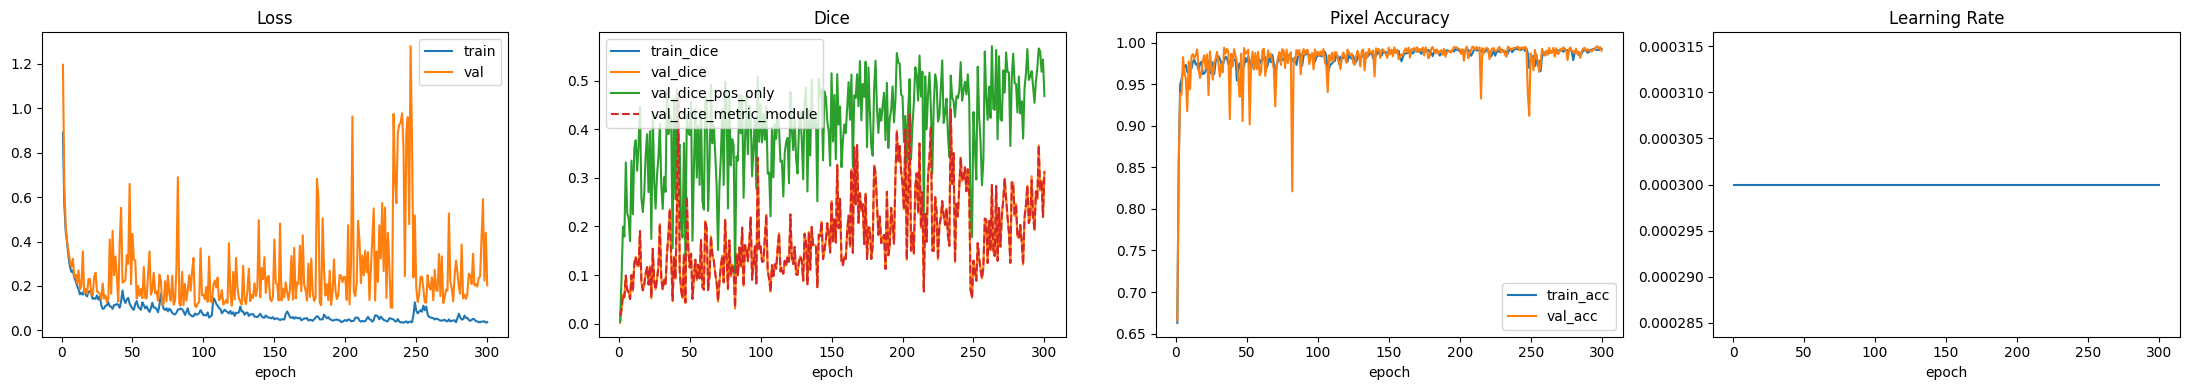

In [20]:
epochs = np.arange(1, len(history["train_loss"]) + 1)
fig, axes = plt.subplots(1, 4, figsize=(22, 4))

axes[0].plot(epochs, history["train_loss"], label="train")
axes[0].plot(epochs, history["val_loss"], label="val")
axes[0].set_title("Loss")
axes[0].set_xlabel("epoch")
axes[0].legend()

axes[1].plot(epochs, history["train_dice"], label="train_dice")
axes[1].plot(epochs, history["val_dice"], label="val_dice")
axes[1].plot(epochs, history["val_dice_pos_only"], label="val_dice_pos_only")
axes[1].plot(epochs, history["val_dice_metric_module"], label="val_dice_metric_module", linestyle="--")
axes[1].set_title("Dice")
axes[1].set_xlabel("epoch")
axes[1].legend()

axes[2].plot(epochs, history["train_accuracy"], label="train_acc")
axes[2].plot(epochs, history["val_accuracy"], label="val_acc")
axes[2].set_title("Pixel Accuracy")
axes[2].set_xlabel("epoch")
axes[2].legend()

axes[3].plot(epochs, history["lr"])
axes[3].set_title("Learning Rate")
axes[3].set_xlabel("epoch")

plt.tight_layout()
plt.show()


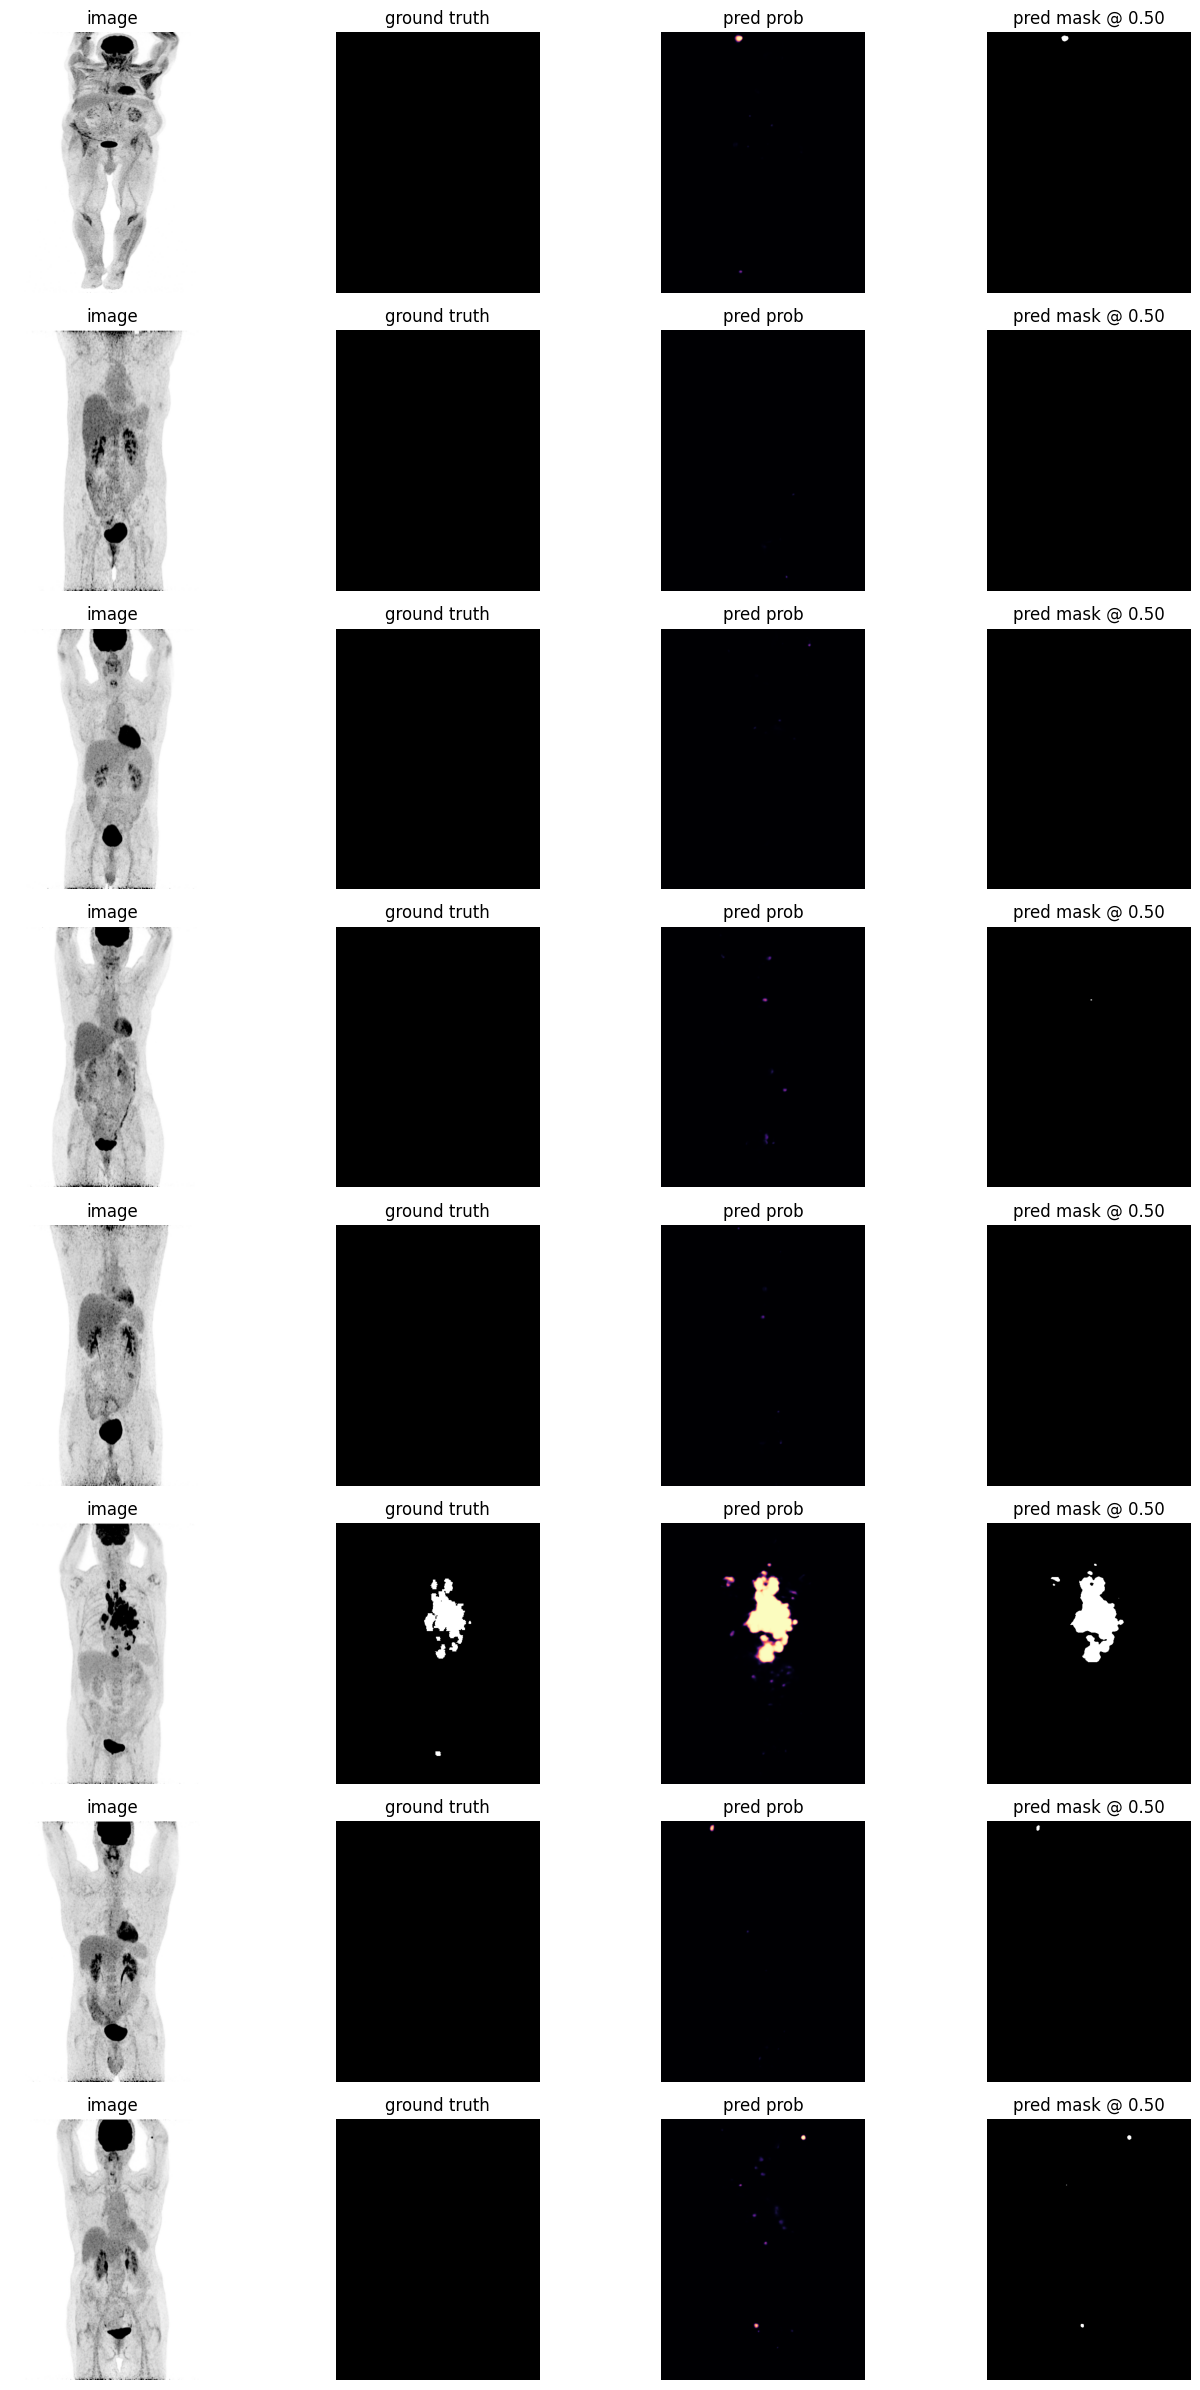

In [21]:
def visualize_predictions(dataset: Subset, num_samples: int = 8, threshold: float | None = None, seed: int = 0) -> None:
    model.eval()
    rng = np.random.default_rng(seed)
    threshold = cfg.threshold if threshold is None else threshold

    picks = rng.choice(len(dataset), size=min(num_samples, len(dataset)), replace=False)

    fig, axes = plt.subplots(len(picks), 4, figsize=(14, 3 * len(picks)))
    if len(picks) == 1:
        axes = np.expand_dims(axes, axis=0)

    with torch.no_grad():
        for row, local_idx in enumerate(picks):
            image, target = dataset[int(local_idx)]
            logits = model(image.unsqueeze(0).to(device))
            probs = torch.sigmoid(logits).squeeze().cpu()
            pred = (probs >= threshold).float()

            image_show = denormalize_image_tensor(image)
            target_np = target[0].cpu().numpy()
            probs_np = probs.numpy()
            pred_np = pred.numpy()

            if image_show.shape[0] == 1:
                axes[row, 0].imshow(image_show[0].numpy(), cmap="gray")
            else:
                axes[row, 0].imshow(image_show.permute(1, 2, 0).numpy())

            axes[row, 1].imshow(target_np, cmap="gray", vmin=0, vmax=1)
            axes[row, 2].imshow(probs_np, cmap="magma", vmin=0, vmax=1)
            axes[row, 3].imshow(pred_np, cmap="gray", vmin=0, vmax=1)

            axes[row, 0].set_title("image")
            axes[row, 1].set_title("ground truth")
            axes[row, 2].set_title("pred prob")
            axes[row, 3].set_title(f"pred mask @ {threshold:.2f}")

            for col in range(4):
                axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


visualize_predictions(val_dataset, num_samples=8)


best overall dice threshold = 0.95, score = 0.5690
best positive-only dice threshold = 0.80, score = 0.6241
threshold selection rule: max precision with recall >= 0.60
selected threshold = 0.95 | precision=0.5875, recall=0.7690, F0.50=0.6166
Updated cfg.threshold to 0.95 for downstream visualizations/evaluation.


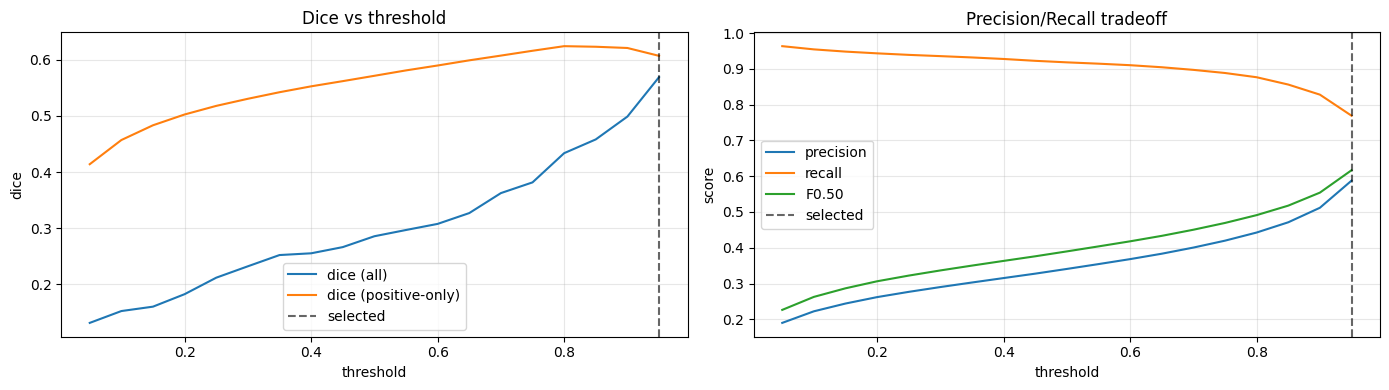

In [22]:
def _binary_confusion_from_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
    threshold: float,
) -> tuple[float, float, float]:
    logits, targets = _prepare_dice_tensors(logits, targets)
    probs = torch.sigmoid(logits)
    preds = probs >= threshold
    targets_bin = targets >= 0.5

    tp = float((preds & targets_bin).sum().item())
    fp = float((preds & (~targets_bin)).sum().item())
    fn = float(((~preds) & targets_bin).sum().item())
    return tp, fp, fn


def threshold_sweep(model: nn.Module, loader: DataLoader, thresholds: np.ndarray) -> dict[str, np.ndarray]:
    model.eval()
    all_scores = []
    pos_scores = []
    precision_scores = []
    recall_scores = []
    fbeta_scores = []

    beta2 = float(cfg.threshold_fbeta_beta) ** 2

    with torch.no_grad():
        for thr in thresholds:
            total = 0.0
            count = 0
            pos_total = 0.0
            pos_count = 0
            tp_total = 0.0
            fp_total = 0.0
            fn_total = 0.0

            for images, targets in loader:
                images = images.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                logits = model(images)

                per_sample = per_sample_dice_from_logits(logits, targets, threshold=float(thr))
                total += float(per_sample.sum().item())
                count += int(per_sample.numel())

                has_pos = targets.reshape(targets.shape[0], -1).sum(dim=1) > 0
                if has_pos.any():
                    pos_total += float(per_sample[has_pos].sum().item())
                    pos_count += int(has_pos.sum().item())

                tp, fp, fn = _binary_confusion_from_logits(logits, targets, threshold=float(thr))
                tp_total += tp
                fp_total += fp
                fn_total += fn

            precision = tp_total / max(tp_total + fp_total, 1.0)
            recall = tp_total / max(tp_total + fn_total, 1.0)
            fbeta = (1.0 + beta2) * precision * recall / max(beta2 * precision + recall, 1e-8)

            all_scores.append(total / max(count, 1))
            pos_scores.append(pos_total / max(pos_count, 1))
            precision_scores.append(precision)
            recall_scores.append(recall)
            fbeta_scores.append(fbeta)

    return {
        "dice_all": np.array(all_scores),
        "dice_pos_only": np.array(pos_scores),
        "precision": np.array(precision_scores),
        "recall": np.array(recall_scores),
        "fbeta": np.array(fbeta_scores),
    }


thresholds = np.linspace(0.05, 0.95, 19)
curves = threshold_sweep(model, val_loader, thresholds)

all_dice_curve = curves["dice_all"]
pos_dice_curve = curves["dice_pos_only"]
precision_curve = curves["precision"]
recall_curve = curves["recall"]
fbeta_curve = curves["fbeta"]

best_all_idx = int(np.argmax(all_dice_curve))
best_pos_idx = int(np.argmax(pos_dice_curve))

valid_recall = recall_curve >= cfg.threshold_min_recall
if valid_recall.any():
    precision_with_constraint = np.where(valid_recall, precision_curve, -1.0)
    best_idx = int(np.argmax(precision_with_constraint))
    selection_rule = f"max precision with recall >= {cfg.threshold_min_recall:.2f}"
else:
    best_idx = int(np.argmax(fbeta_curve))
    selection_rule = f"fallback max F{cfg.threshold_fbeta_beta:.2f}"

cfg.threshold = float(thresholds[best_idx])

print(f"best overall dice threshold = {thresholds[best_all_idx]:.2f}, score = {all_dice_curve[best_all_idx]:.4f}")
print(f"best positive-only dice threshold = {thresholds[best_pos_idx]:.2f}, score = {pos_dice_curve[best_pos_idx]:.4f}")
print(f"threshold selection rule: {selection_rule}")
print(
    f"selected threshold = {cfg.threshold:.2f} | "
    f"precision={precision_curve[best_idx]:.4f}, "
    f"recall={recall_curve[best_idx]:.4f}, "
    f"F{cfg.threshold_fbeta_beta:.2f}={fbeta_curve[best_idx]:.4f}"
)
print(f"Updated cfg.threshold to {cfg.threshold:.2f} for downstream visualizations/evaluation.")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(thresholds, all_dice_curve, label="dice (all)")
axes[0].plot(thresholds, pos_dice_curve, label="dice (positive-only)")
axes[0].axvline(cfg.threshold, color="black", linestyle="--", alpha=0.6, label="selected")
axes[0].set_xlabel("threshold")
axes[0].set_ylabel("dice")
axes[0].set_title("Dice vs threshold")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(thresholds, precision_curve, label="precision")
axes[1].plot(thresholds, recall_curve, label="recall")
axes[1].plot(thresholds, fbeta_curve, label=f"F{cfg.threshold_fbeta_beta:.2f}")
axes[1].axvline(cfg.threshold, color="black", linestyle="--", alpha=0.6, label="selected")
axes[1].set_xlabel("threshold")
axes[1].set_ylabel("score")
axes[1].set_title("Precision/Recall tradeoff")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


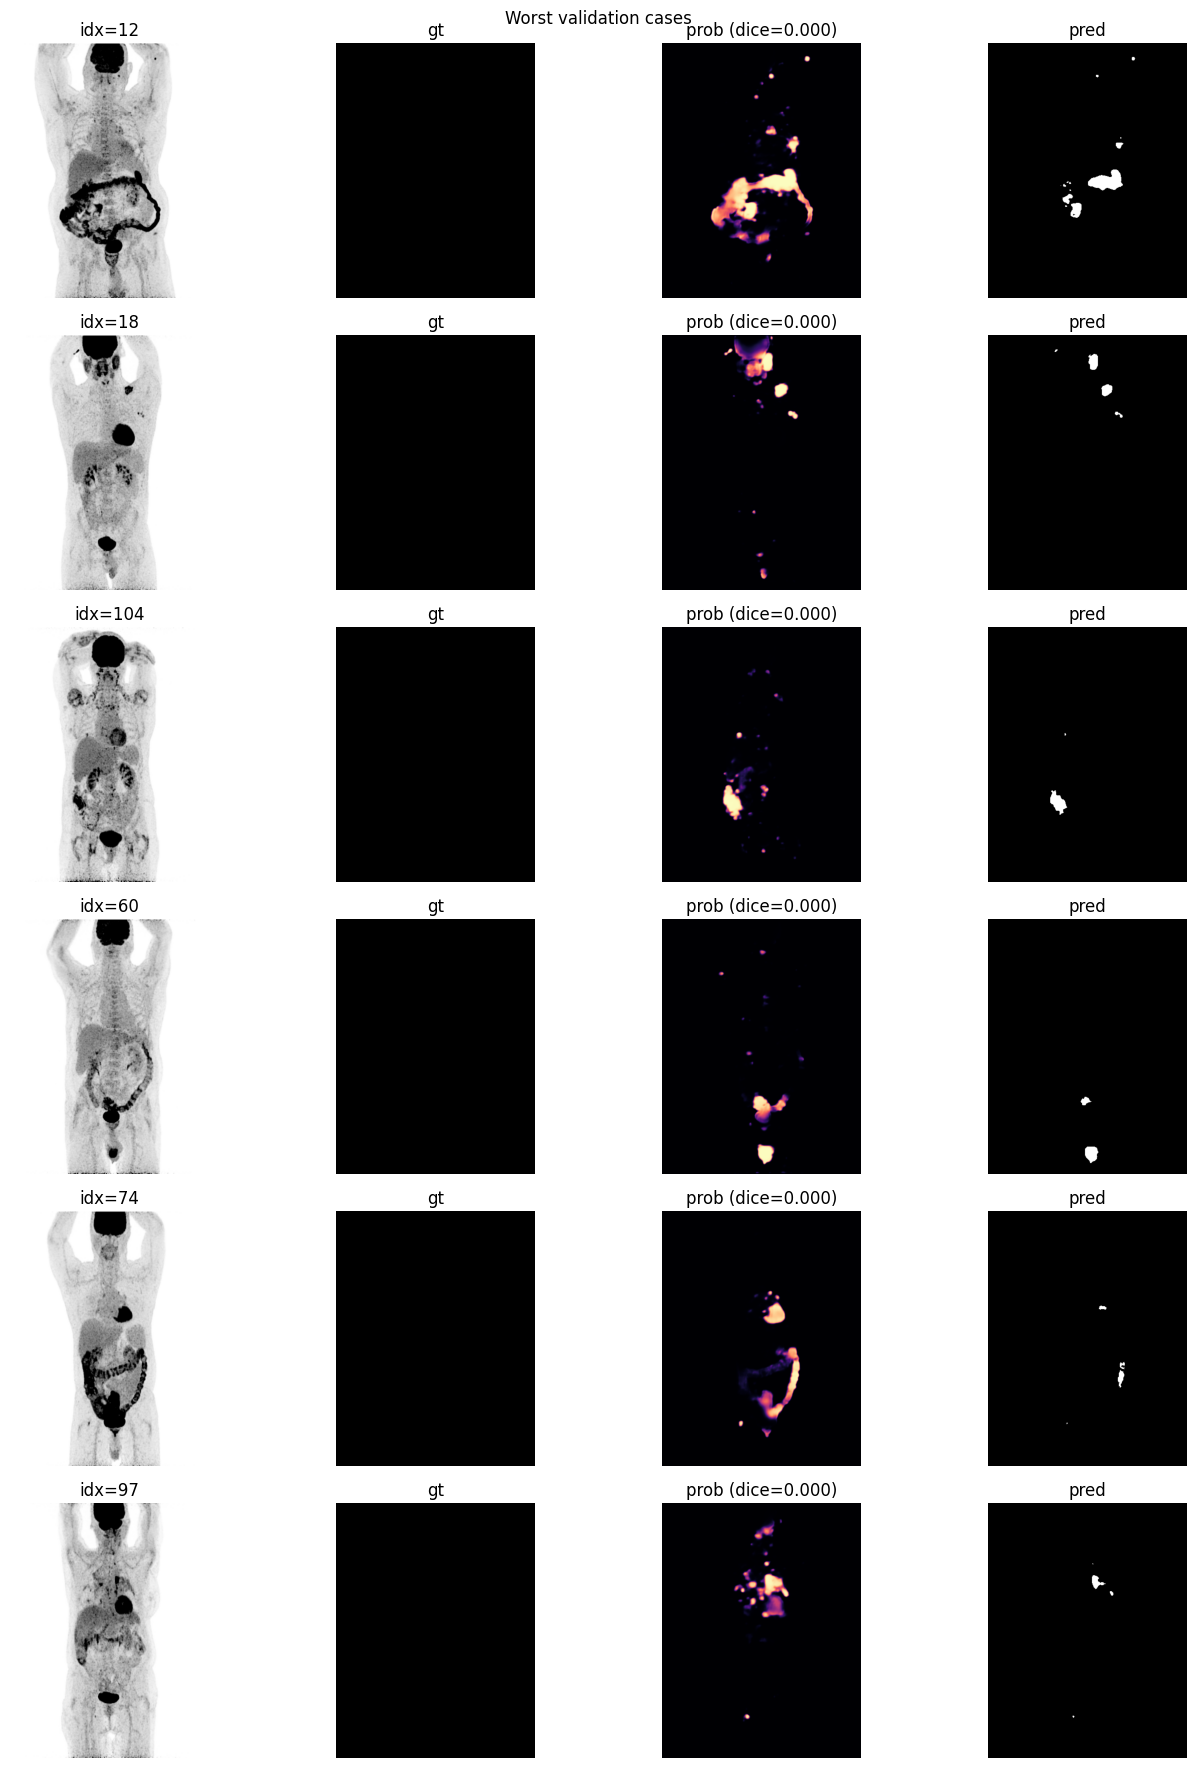

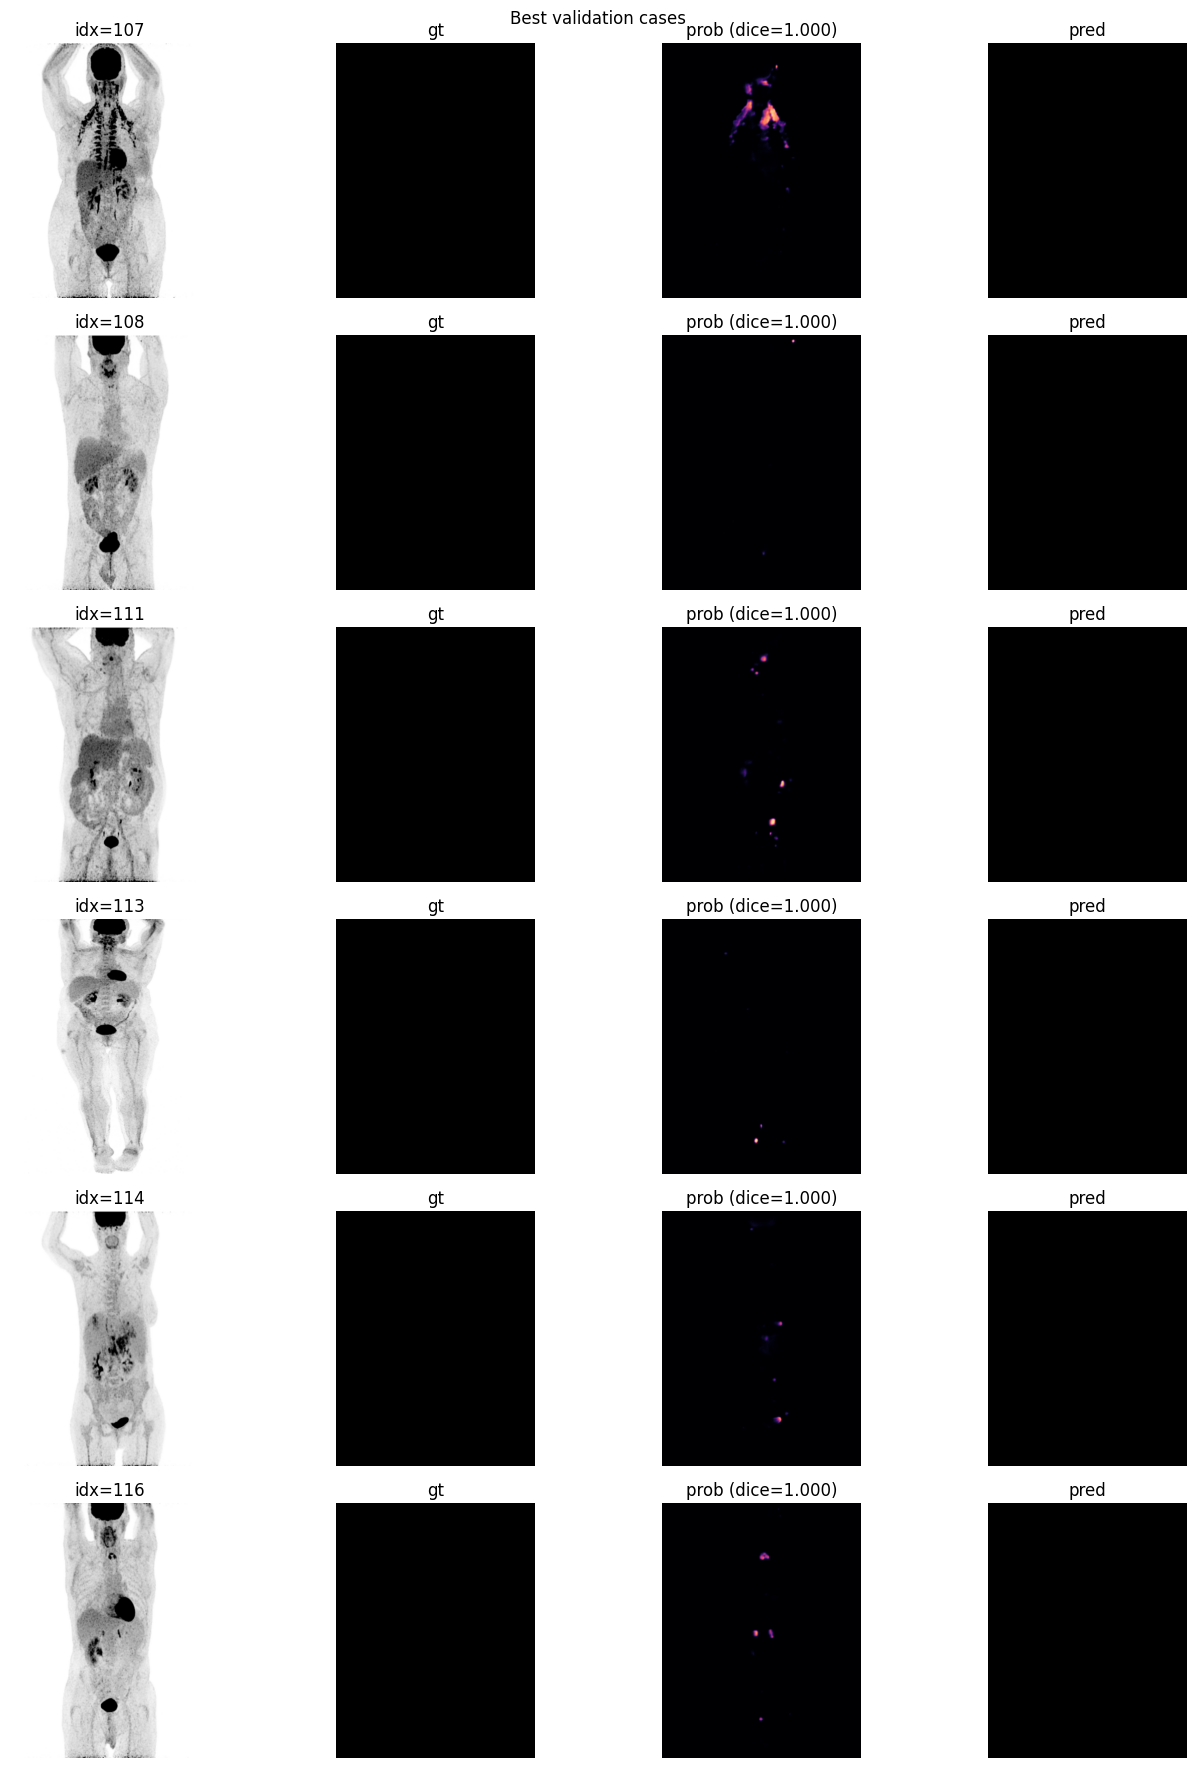

In [23]:
def collect_hard_cases(dataset: Subset, num_cases: int = 6, threshold: float | None = None):
    model.eval()
    threshold = cfg.threshold if threshold is None else threshold

    records = []
    with torch.no_grad():
        for i in range(len(dataset)):
            image, target = dataset[i]
            logits = model(image.unsqueeze(0).to(device))
            score = float(per_sample_dice_from_logits(logits, target.unsqueeze(0).to(device), threshold=threshold)[0].item())
            records.append((score, i, image.cpu(), target.cpu(), torch.sigmoid(logits).squeeze().cpu()))

    records.sort(key=lambda x: x[0])
    return records[:num_cases], records[-num_cases:]


def show_case_records(records, title: str, threshold: float | None = None):
    threshold = cfg.threshold if threshold is None else threshold
    fig, axes = plt.subplots(len(records), 4, figsize=(14, 3 * len(records)))
    if len(records) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, (score, idx, image, target, prob) in enumerate(records):
        image_show = denormalize_image_tensor(image)
        pred = (prob >= threshold).float()

        if image_show.shape[0] == 1:
            axes[r, 0].imshow(image_show[0].numpy(), cmap="gray")
        else:
            axes[r, 0].imshow(image_show.permute(1, 2, 0).numpy())

        axes[r, 1].imshow(target[0].numpy(), cmap="gray", vmin=0, vmax=1)
        axes[r, 2].imshow(prob.numpy(), cmap="magma", vmin=0, vmax=1)
        axes[r, 3].imshow(pred.numpy(), cmap="gray", vmin=0, vmax=1)

        axes[r, 0].set_title(f"idx={idx}")
        axes[r, 1].set_title("gt")
        axes[r, 2].set_title(f"prob (dice={score:.3f})")
        axes[r, 3].set_title("pred")

        for c in range(4):
            axes[r, c].axis("off")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


worst_cases, best_cases = collect_hard_cases(val_dataset, num_cases=6)
show_case_records(worst_cases, "Worst validation cases")
show_case_records(best_cases, "Best validation cases")


In [24]:
# Optional quick ablation to compare encoder pretraining choices for this PET setup.
# This runs short experiments and compares best val_dice_pos_only.

def run_short_experiment(encoder_weights: str | None, epochs: int = 8) -> float:
    local_model = smp.Unet(
        encoder_name=cfg.encoder_name,
        encoder_weights=encoder_weights,
        in_channels=cfg.image_channels,
        classes=cfg.classes,
        activation=cfg.activation,
    ).to(device)

    local_optimizer = torch.optim.AdamW(local_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    local_scaler = build_grad_scaler(enabled=use_amp)

    def local_run_epoch(loader: DataLoader, train: bool):
        local_model.train(mode=train)
        pos_best = 0.0
        total_pos = 0.0
        pos_count = 0
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)

            with torch.set_grad_enabled(train):
                with autocast_context():
                    logits = local_model(images)
                    loss = repo_dice_loss(logits, targets)

                if train:
                    local_optimizer.zero_grad(set_to_none=True)
                    if use_amp:
                        local_scaler.scale(loss).backward()
                        local_scaler.step(local_optimizer)
                        local_scaler.update()
                    else:
                        loss.backward()
                        local_optimizer.step()

            with torch.no_grad():
                d = per_sample_dice_from_logits(logits, targets, threshold=cfg.threshold)
                has_pos = targets.reshape(targets.shape[0], -1).sum(dim=1) > 0
                if has_pos.any():
                    total_pos += float(d[has_pos].sum().item())
                    pos_count += int(has_pos.sum().item())

        return total_pos / max(pos_count, 1)

    best = -1.0
    for _ in range(epochs):
        _ = local_run_epoch(train_loader, train=True)
        val_pos = local_run_epoch(val_loader, train=False)
        best = max(best, val_pos)

    return best


# Uncomment to run:
# for w in [None, "imagenet"]:
#     score = run_short_experiment(encoder_weights=w, epochs=8)
#     print(f"encoder_weights={w}: best val_dice_pos_only={score:.4f}")
